In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 0. Introduction: how does the Law School system work in the United States? 
This system is highly different than the Italian one, and therefore it needs to be understood in order to carry on this analysis of bias. 

1. The student goes to an undergraduate degree (variable ugpa)
2. The student takes the lsat (variable lsat)
3. The student is assigned to a decile (1-10, where 1 is the lowest score and 10 is the highest, indicating your starting position in law school)
4. The student attends law school
5. The student sits the bar exam, which they can pass or not pass (this is our target variable)

In [139]:
df = pd.read_csv('/Users/kristinabaycheva/Desktop/Ethics_project/bar_pass_prediction.csv')
df.shape

(22407, 39)

In [140]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [141]:
df.head()

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


- checking for duplicates and null values

In [142]:
df.isnull().sum().sort_values(ascending=False)

decile1b                   1604
decile3                    1604
zgpa                       1289
decile1                    1092
zfygpa                      984
fam_inc                     289
cluster                      96
tier                         96
age                          89
DOB_yr                       50
bar2_yr                      40
bar1_yr                      39
parttime                     34
fulltime                     34
race                         16
race1                        16
race2                        16
male                          5
sex                           5
gender                        5
grad                          3
ID                            0
bar1                          0
bar2                          0
ugpa                          0
lsat                          0
Dropout                       0
asian                         0
black                         0
hisp                          0
other                         0
pass_bar

the columns which contain most null values are: 

decile1b                   
decile3                    
zgpa                       
decile1                    

Also, neither the target variable pass_bar nor the id column contain null values, which is extremely good as it simplifies the preprocessing step. 

In [143]:
for column in df.columns:
    num_duplicates = df[column].duplicated().sum()
    print(f"Column '{column}' has {num_duplicates} duplicate values.")

Column 'decile1b' has 22396 duplicate values.
Column 'decile3' has 22396 duplicate values.
Column 'ID' has 0 duplicate values.
Column 'decile1' has 22396 duplicate values.
Column 'sex' has 22404 duplicate values.
Column 'race' has 22398 duplicate values.
Column 'cluster' has 22400 duplicate values.
Column 'lsat' has 22291 duplicate values.
Column 'ugpa' has 22382 duplicate values.
Column 'zfygpa' has 21843 duplicate values.
Column 'DOB_yr' has 22355 duplicate values.
Column 'grad' has 22403 duplicate values.
Column 'zgpa' has 21818 duplicate values.
Column 'bar1' has 22405 duplicate values.
Column 'bar1_yr' has 22402 duplicate values.
Column 'bar2' has 22405 duplicate values.
Column 'bar2_yr' has 22402 duplicate values.
Column 'fulltime' has 22404 duplicate values.
Column 'fam_inc' has 22401 duplicate values.
Column 'age' has 22349 duplicate values.
Column 'gender' has 22404 duplicate values.
Column 'parttime' has 22404 duplicate values.
Column 'male' has 22404 duplicate values.
Column

- correlation matrix 

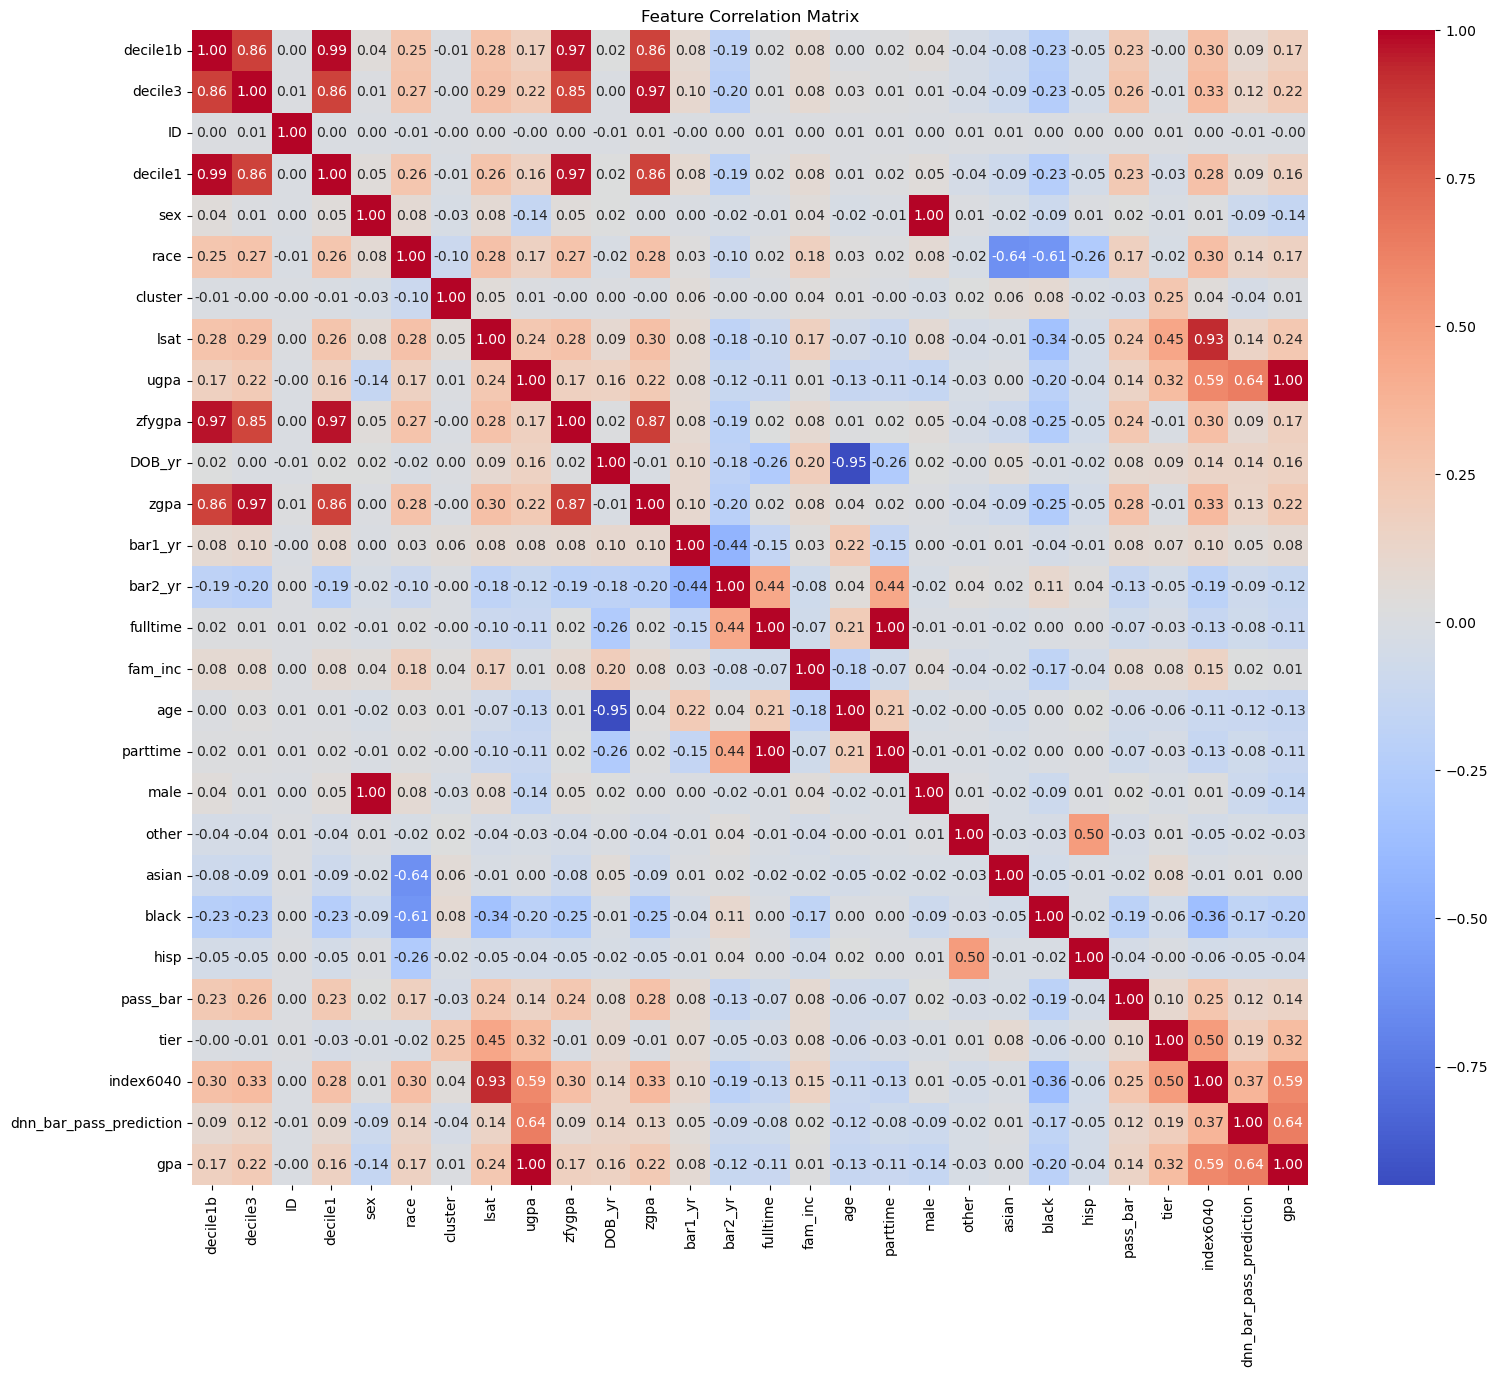

In [144]:
# only considering the numeric columns 
numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(18, 15))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

There seem to be features which are extremely correlated amongst themselves, therefore they need to be analyzed and understood to see if they contain useful information or they need to be dropped. 

### 1. Dropping useless columns

Immediately, we have to drop the column which represents the output of a previous model applied on this dataset, as it will not hold any significance since we want to apply our own model. 

Furthermore, in the description of the dataset, it was explicitated that bar pass and passed_bar are the same column encoded in two different ways, one boolean (True, False) and the other is 

In [145]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [146]:
df.drop('dnn_bar_pass_prediction', axis=1, inplace=True)

In [147]:
# Boolean series where values differ
differences = df['pass_bar'] != df['bar_passed']

# Count mismatches
num_different = differences.sum()
print("Number of differing values:", num_different)


Number of differing values: 1


They are actually not the same so they need to be investigated further

In [148]:
differences = df['pass_bar'] != df['bar_passed']
print("\nRows with mismatched values:")
df.loc[differences]


Rows with mismatched values:


,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,black,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,gpa
7020,NaN,NaN,11929,7.0,1.0,7.0,3.0,39.5,3.2,0.36,...,0,0,1,e non-Grad,False,3.0,785.789454,g 700+,h 760-820,3.2


Let's do a quick analysis of the target variable pass_bar

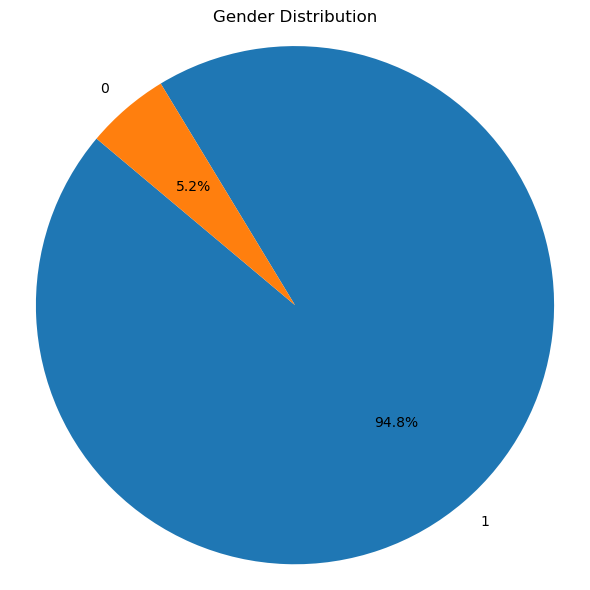

In [149]:
barresults = df['pass_bar'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(barresults, labels=barresults.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.axis('equal') 
plt.tight_layout()
plt.show()

In [150]:
df['pass_bar'].value_counts()

pass_bar
1    21238
0     1169
Name: count, dtype: int64

1161 students didn't pass the exam (5.2% of the total)

- **gender**

In [151]:
#columns to consider are sex, gender and male
gender_cols = ['sex', 'gender', 'male']
for col in gender_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: sex
Unique values: [ 1.  2. nan]
Value counts:
 sex
2.0    12576
1.0     9826
NaN        5
Name: count, dtype: int64

Column: gender
Unique values: ['female' 'male' nan]
Value counts:
 gender
male      12576
female     9826
NaN           5
Name: count, dtype: int64

Column: male
Unique values: [ 0.  1. nan]
Value counts:
 male
1.0    12576
0.0     9826
NaN        5
Name: count, dtype: int64


it appears as if the three column encode the same information, which is the amount of male and female students. 
- sex is an encoding of the gender column where the value 2.0 indicates the male students and 1.0 the female ones. 
- gender is the categorical variable which contains the words 'male' and 'female'
- male instead is a binary encoding of the categorical column

*proposed course of action*: keeping numerical features is in general easier, especially for bias mitigation techniques. Therefore the 'male' column will be kept. Also, since the percentage of missing values is so small compared to the size of the dataset, these can be dropped without worry that we will lose valuable information. 

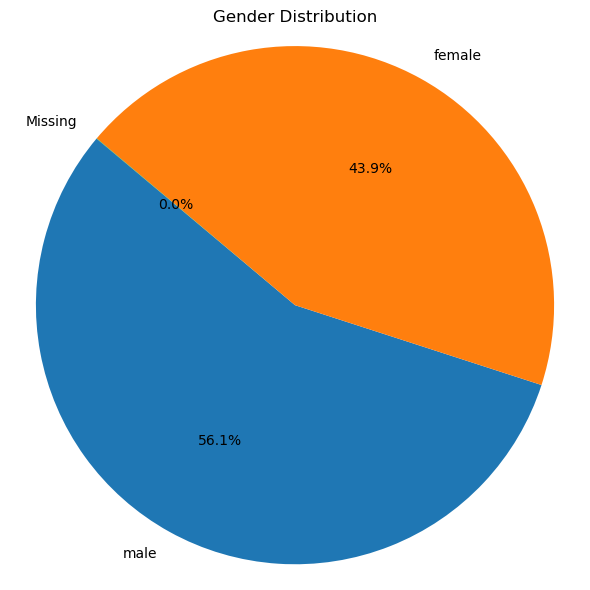

In [152]:
gender_counts = df['gender'].value_counts(dropna=False)

gender_counts_plot = gender_counts.copy()
gender_counts_plot.index = gender_counts_plot.index.fillna('Missing')

plt.figure(figsize=(6, 6))
plt.pie(gender_counts_plot, labels=gender_counts_plot.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.axis('equal') 
plt.tight_layout()
plt.show()


In [153]:
df.dropna(subset=['gender', 'sex', 'male'], inplace=True)

In [154]:
#columns to consider are sex, gender and male
gender_cols = ['sex', 'gender', 'male']
for col in gender_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: sex
Unique values: [1. 2.]
Value counts:
 sex
2.0    12576
1.0     9826
Name: count, dtype: int64

Column: gender
Unique values: ['female' 'male']
Value counts:
 gender
male      12576
female     9826
Name: count, dtype: int64

Column: male
Unique values: [0. 1.]
Value counts:
 male
1.0    12576
0.0     9826
Name: count, dtype: int64


In [155]:
# keeping the binary encoded column male, which indicates wether a student is male (1) or female (0) and the gender column
df.drop(columns=['sex'], inplace=True)

**analysis**: in this specific case, the imbalance between male and female students extists, but it is not overwhelming. 

<Figure size 800x600 with 0 Axes>

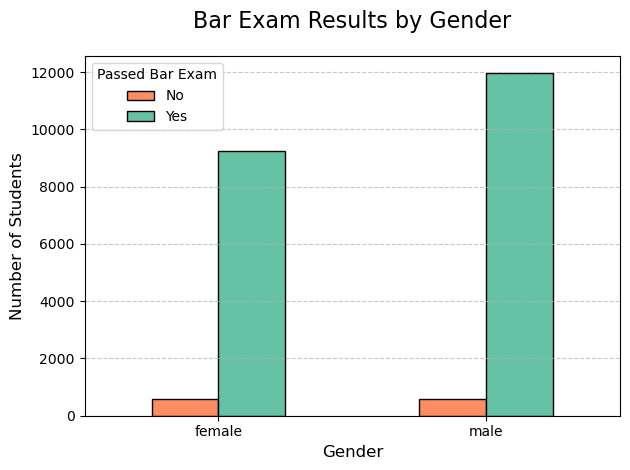

In [156]:
gender_pass_counts = df.groupby(['gender', 'pass_bar']).size().unstack(fill_value=0)

# Plot grouped bar chart (not stacked)
plt.figure(figsize=(8, 6))
gender_pass_counts.plot(
    kind='bar',
    stacked=False,
    color=['#fc8d62', '#66c2a5'],  # [Did not pass, Passed]
    edgecolor='black'
)

# Formatting
plt.title('Bar Exam Results by Gender', fontsize=16, pad=20)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Passed Bar Exam', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [157]:
gender_totals = df['gender'].value_counts()
gender_passed = df[df['pass_bar'] == True]['gender'].value_counts()

pass_rates = (gender_passed / gender_totals) * 100

male_rate = pass_rates.get('male', 0)
female_rate = pass_rates.get('female', 0)

diff = male_rate - female_rate

# Print natural language summary
if diff > 0:
    print(f"{diff:.1f}% more males passed the bar exam compared to females.")
elif diff < 0:
    print(f"{-diff:.1f}% more females passed the bar exam compared to males.")
else:
    print("The pass rate is the same for males and females.")


1.0% more males passed the bar exam compared to females.


- **race**

In [158]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'race', 'cluster', 'lsat',
       'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2',
       'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime', 'male',
       'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'gpa'],
      dtype='object')

In [159]:
# the columns to consider are race race2 race1 other asian black hisp
race_cols = ['race', 'race2', 'race1', 'other', 'asian', 'black', 'hisp']
for col in race_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: race
Unique values: [ 7.  4.  2.  3.  6. nan  8.  1.  5.]
Value counts:
 race
7.0    18713
3.0     1342
2.0      897
6.0      506
4.0      396
8.0      303
5.0      125
1.0      105
NaN       15
Name: count, dtype: int64

Column: race2
Unique values: ['b white' 'c other' 'a black' nan]
Value counts:
 race2
b white    18713
c other     2332
a black     1342
NaN           15
Name: count, dtype: int64

Column: race1
Unique values: ['white' 'hisp' 'asian' 'black' nan 'other']
Value counts:
 race1
white    18713
black     1342
hisp      1027
asian      897
other      408
NaN         15
Name: count, dtype: int64

Column: other
Unique values: [0 1]
Value counts:
 other
0    21994
1      408
Name: count, dtype: int64

Column: asian
Unique values: [0 1]
Value counts:
 asian
0    21505
1      897
Name: count, dtype: int64

Column: black
Unique values: [0 1]
Value counts:
 black
0    21060
1     1342
Name: count, dtype: int64

Column: hisp
Unique values: [0 1]
Value counts:
 hisp
0    22

In [160]:
#check to see if the students present in two columns are the same ones
print('Number of black students in one column and not the other: ' + str(df[(df['black'] == 1) & (df['race1'] != 'black')].shape[0]))

Number of black students in one column and not the other: 0


*hypothesis*: the columns 'black', 'hisp', 'asian', 'other' encode binarily what is expressed by the race1 column. The discrepancy is instead in the hispanic students, which seem to be less in the hisp column compared to the ones labelled as 'hisp' in the race1 column.

In [161]:
print('Number of hispanic students in one column and not the other: ' + str(df[(df['hisp'] == 1) & (df['race1'] != 'hisp')].shape[0]))

Number of hispanic students in one column and not the other: 105


This further enforces the idea that the hisp column might be either encoded wrongly or not represent information which is truthful, especially because this dataset mimics data from the US, which is a country with a very high percentage of hispanic population, therefore we would expect a number higher than 105. This is why we believe that the column 'race1' better encodes the information. 

In [162]:
print('Number of asian students in one column and not the other: ' + str(df[(df['asian'] == 1) & (df['race1'] != 'asian')].shape[0]))

Number of asian students in one column and not the other: 0


The number of asian student matches. 

The race2 column instead provides more focus on the discrepancy between the two majority classes: white and black, while all other races are grouped into the 'other' label. We believe that this column is oversimplistic and although it can be interesting to study in further projects, we believe it is not as informative as race1. 

Instead, the column which seems to better convey the information is the 'race' one. This one, though, does not have a categorical value associated to the numbers. We can tell which are the white, black and asian students from the number of entries for each value, but nothing is to be said on the others. This means that, although specific, this information is not useful to the end of this analysis. 

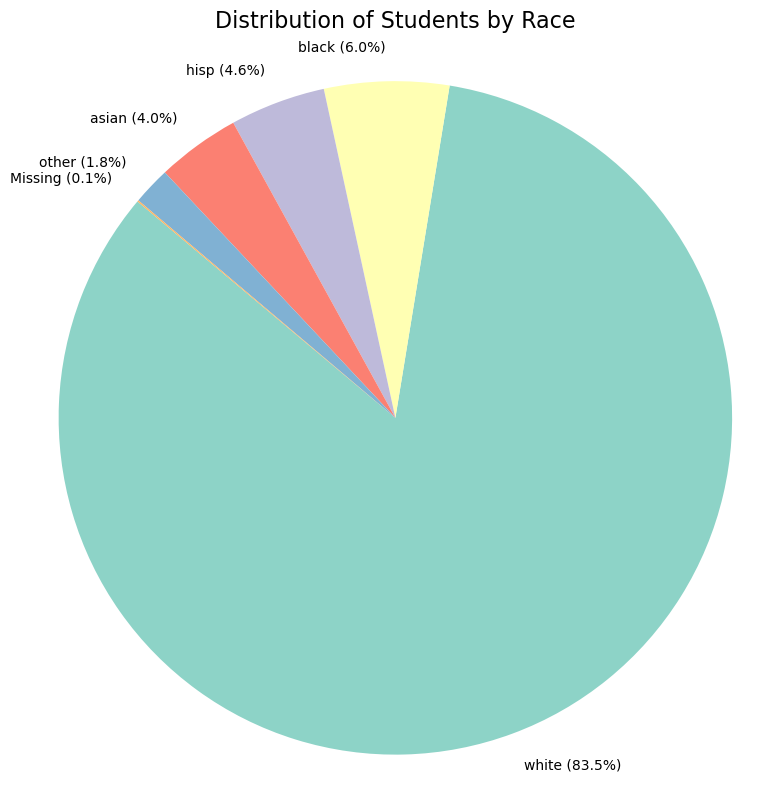

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

race_counts = df['race1'].fillna('Missing').value_counts()
total = race_counts.sum()

# Create labels with percentages next to category names
labels_with_pct = [
    f"{label} ({count / total:.1%})" for label, count in race_counts.items()
]

# Define a clean color palette
colors = plt.cm.Set3.colors 

plt.figure(figsize=(8, 8))
plt.pie(
    race_counts,
    labels=labels_with_pct,
    startangle=140,
    colors=colors,
    labeldistance=1.1,
    textprops={'fontsize': 10}
)

plt.title('Distribution of Students by Race', fontsize=16, pad=20)
plt.axis('equal')
plt.tight_layout()


Also in this case the missing values are an extremely low percentage, and therefore can be dropped without consequences. Furthermore, also all the numerical columns will be dropped and only race1 and race2 are going to be kept. 

In [164]:
df.dropna(subset=['race1', 'race2'], inplace=True)
df.drop(columns=['other', 'black', 'asian', 'hisp'], inplace=True)

**analysis**: the dataset shows evident distributional imbalance in favour of white students, which are overrepresented in the dataset. This is of course a form of representational bias and needs to be investigated further. When training ML models this can be a hazard as it can lead the model trained on this data to rely on a feature like race to predict wether a student will pass or not the exam. 

Because of this reason, the model itself can be biased, and therefore perpetrating stereotypes which are to be broken in order to use AI in contexts where sensitive information is used to make predictions. 

<Figure size 1000x600 with 0 Axes>

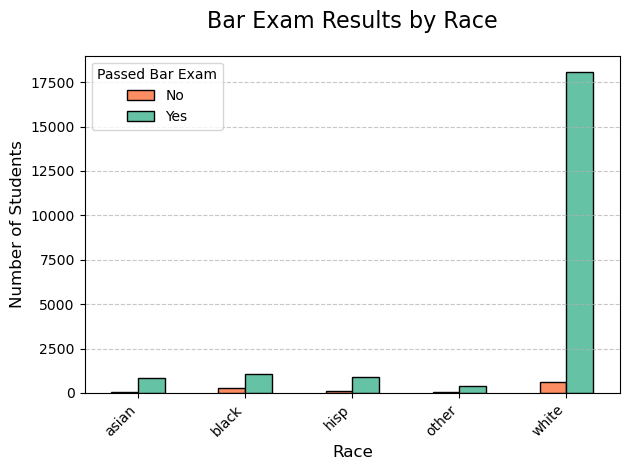

In [165]:
race_pass_counts = df.groupby(['race1', 'pass_bar']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
race_pass_counts.plot(
    kind='bar',
    stacked=False,
    color=['#fc8d62', '#66c2a5'],  # [Did not pass, Passed]
    edgecolor='black'
)

# Formatting
plt.title('Bar Exam Results by Race', fontsize=16, pad=20)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Passed Bar Exam', labels=['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


Of course, the bias is evident, but we should look at it in terms of ratios and percentages to see if the unbalanced results are due to representation or bias might be present in this feature. 

In [166]:
race_pass_counts = df.groupby(['race1', 'pass_bar']).size().unstack(fill_value=0)

# Rename columns for clarity
race_pass_counts.columns = ['Did Not Pass', 'Passed']

# Calculate ratio of Passed to Did Not Pass
race_pass_counts['Pass/Fail Ratio'] = race_pass_counts['Passed'] / race_pass_counts['Did Not Pass']

# Display the result sorted by ratio
print(race_pass_counts[['Passed', 'Did Not Pass', 'Pass/Fail Ratio']].sort_values(by='Pass/Fail Ratio', ascending=False))


       Passed  Did Not Pass  Pass/Fail Ratio
race1                                       
white   18084           629        28.750397
asian     827            70        11.814286
other     366            42         8.714286
hisp      899           128         7.023438
black    1044           298         3.503356


In [167]:
# Count total students and how many passed, per race
race_totals = df['race1'].value_counts()
race_passed = df[df['pass_bar'] == True]['race1'].value_counts()

# Compute pass rate as a percentage
pass_rate = (race_passed / race_totals) * 100

# Combine into a readable DataFrame
pass_rate_df = pd.DataFrame({
    'Total Students': race_totals,
    'Passed': race_passed,
    'Pass Rate (%)': pass_rate
}).fillna(0).sort_values(by='Pass Rate (%)', ascending=False)

# Print results
print(pass_rate_df)


       Total Students  Passed  Pass Rate (%)
race1                                       
white           18713   18084      96.638700
asian             897     827      92.196210
other             408     366      89.705882
hisp             1027     899      87.536514
black            1342    1044      77.794337


There is a big gap between white and black students, or in general between black students and students of any other race, even if black applicants were the second most noumerous group in terms of attendants at the exam. This suggests the presence of bias at the expense of black people. We can investigate this further by looking at the 'race2' column. 

In [168]:
df.race2.value_counts()

race2
b white    18713
c other     2332
a black     1342
Name: count, dtype: int64

In [169]:
# Count total students and how many passed, per race
race_totals = df['race2'].value_counts()
race_passed = df[df['pass_bar'] == True]['race2'].value_counts()

# Compute pass rate as a percentage
pass_rate = (race_passed / race_totals) * 100

# Combine into a readable DataFrame
pass_rate_df = pd.DataFrame({
    'Total Students': race_totals,
    'Passed': race_passed,
    'Pass Rate (%)': pass_rate
}).fillna(0).sort_values(by='Pass Rate (%)', ascending=False)

# Print results
print(pass_rate_df)


         Total Students  Passed  Pass Rate (%)
race2                                         
b white           18713   18084      96.638700
c other            2332    2092      89.708405
a black            1342    1044      77.794337


For sure the race feature might be problematic when analyzing for bias, and therefore needs to be kept in check and ensure that the trained models do not reflect this. 

The bias needs to be investigated further with appropriate tenchiques that go beyond simple ratios and might have to be removed through proper debiasing techniques in preprocessing (before any model is trained).

- **age**

In [170]:
age_cols = ['DOB_yr', 'age']

In [171]:
for col in age_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: DOB_yr
Unique values: [69. 65. 58. 68. 55. 67. 70. 61. 66. 51. 56. 54. 62. 64. 49. 60. 59. 52.
 63. 57. 50. 71. 53. 37. 44. 46. 48. 24. 47. 42. 34. 41. 45. nan 33. 43.
 40. 16. 39. 38. 36. 29. 15. 35. 32. 10. 28. 12. 25. 14. 20. 31.]
Value counts:
 DOB_yr
69.0    6058
68.0    4283
67.0    2622
66.0    1754
65.0    1250
64.0    1023
63.0     771
62.0     602
70.0     565
61.0     501
60.0     405
59.0     331
58.0     277
57.0     257
56.0     224
55.0     183
54.0     180
52.0     159
53.0     138
51.0     127
49.0      97
50.0      94
47.0      77
48.0      65
46.0      63
NaN       50
71.0      36
45.0      34
44.0      30
43.0      25
42.0      20
41.0      16
40.0      14
38.0       9
39.0       8
36.0       5
32.0       4
33.0       4
37.0       4
34.0       4
12.0       3
25.0       2
28.0       2
10.0       2
31.0       2
24.0       1
29.0       1
16.0       1
35.0       1
15.0       1
14.0       1
20.0       1
Name: count, dtype: int64

Column: age
Unique values: [-62.

The values found in this column contain unexpected values. Since this dataset is manmade and we cannot know when this was made, it makes no sense to keep the date of birth, as it gives us no information about the age of the student. 

The age column, instead, does not contain values compatible with ages appropriate for passing a bar exam. According to statistics, the average age at which people sit the bar exam is around 31 years old, which here only has 11 entries. 

These columns should be dropped therefore as they do not contain any useful information. Before doing this it is good to check the correlation with the target variable to ensure we are not losing predictive features. 

<Axes: >

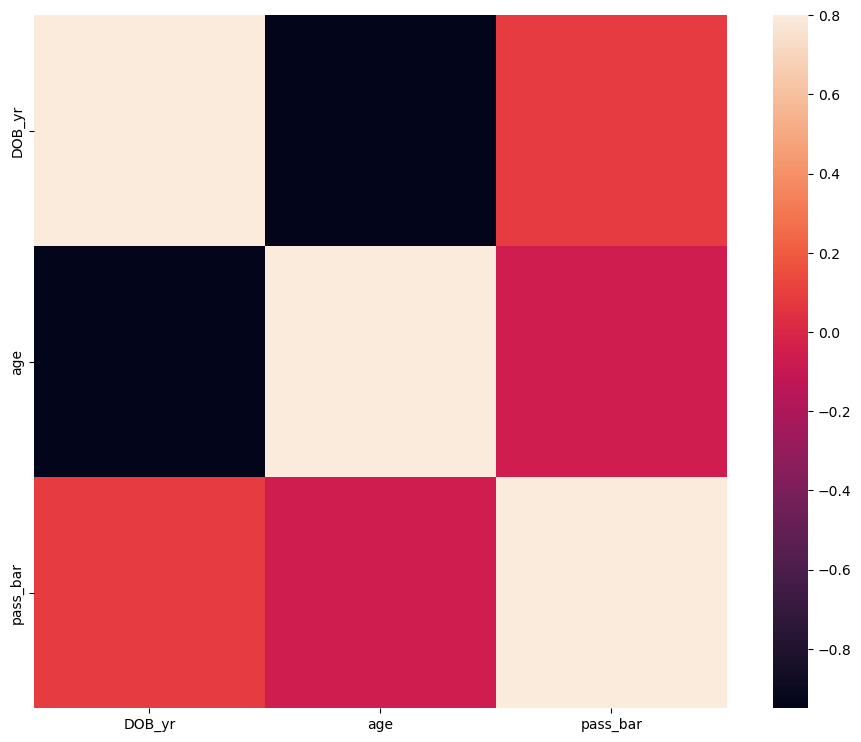

In [172]:
df_age = df[['DOB_yr', 'age', 'pass_bar']]
corrmat = df_age.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [173]:
df.drop(columns=age_cols, inplace=True)

- ### **gpa and academic career**

- gpa and ugpa represent the undergraduate gpa (identical according to correlation matrix)
- zgpa is the standardized final law school GPA
- lsat is the lsat score that a student got
- zfygpa represents the standardized first-year law GPA


- **gpa and ugpa**

In [174]:
all_equal = (df['gpa'] == df['ugpa']).all()
print("Do all values match exactly?:", all_equal)

Do all values match exactly?: True


In [175]:
#dropping gpa and keeping only ugpa where u = undergraduate
df.drop(columns=['gpa'], inplace=True)

In [176]:
df['ugpa'].isnull().sum()

np.int64(0)

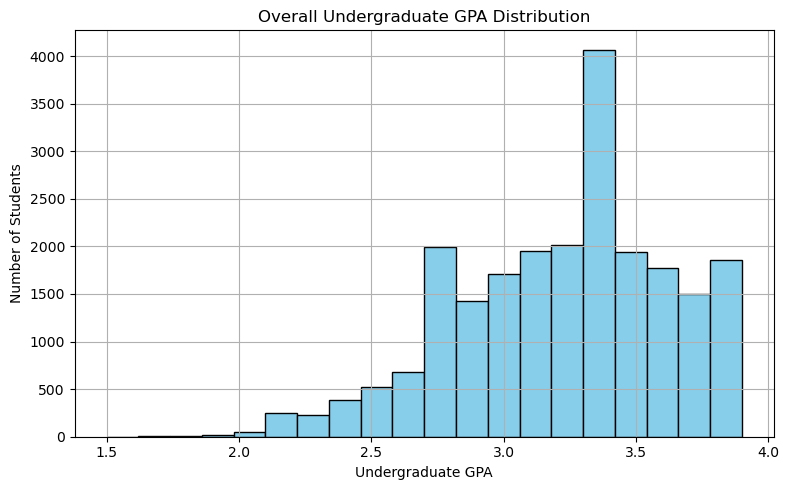

In [177]:
plt.figure(figsize=(8, 5))
df['ugpa'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Undergraduate GPA')
plt.ylabel('Number of Students')
plt.title('Overall Undergraduate GPA Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
print("\nAverage UGPA (Overall):")
print(df['ugpa'].mean())


Average UGPA (Overall):
3.2154062625630946


Now let's see how it correlates to passing the bar exam

In [179]:
print("\nAverage UGPA by Pass/Fail:")
print(df.groupby('pass_bar')['ugpa'].mean())


Average UGPA by Pass/Fail:
pass_bar
0    2.969323
1    3.228940
Name: ugpa, dtype: float64


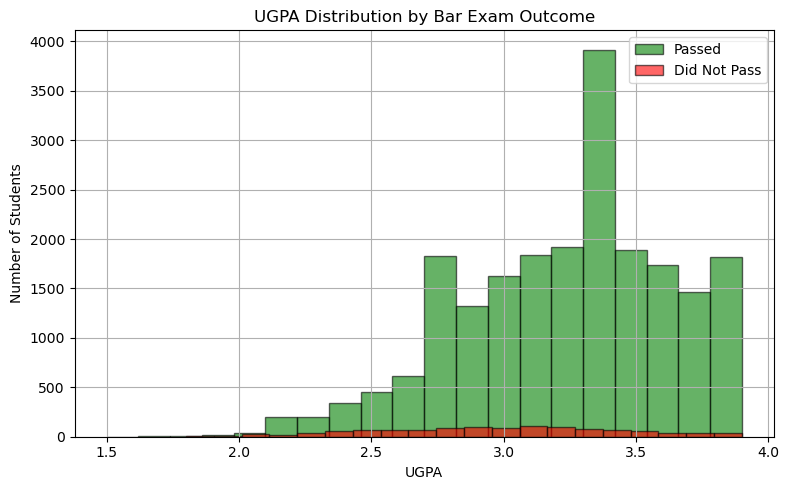

In [180]:
plt.figure(figsize=(8, 5))
df[df['pass_bar'] == True]['ugpa'].hist(alpha=0.6, label='Passed', bins=20, color='green', edgecolor='black')
df[df['pass_bar'] == False]['ugpa'].hist(alpha=0.6, label='Did Not Pass', bins=20, color='red', edgecolor='black')
plt.xlabel('UGPA')
plt.ylabel('Number of Students')
plt.title('UGPA Distribution by Bar Exam Outcome')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **lsat**

In [181]:
df.lsat.isnull().sum()

np.int64(0)

In [182]:
df.lsat.value_counts()

lsat
37.0    1619
39.0    1536
40.0    1485
36.0    1445
38.0    1395
        ... 
40.7       1
11.0       1
38.3       1
15.7       1
19.7       1
Name: count, Length: 116, dtype: int64

these values are surprising as the LSAT exam has scores that range between 120 and 180, so some data manipulation was probably performed. Still, for the sake of the exercise, we are going to keep these as the proper scores. 

In [183]:
print("LSAT Summary:")
print(df['lsat'].describe())

LSAT Summary:
count    22387.000000
mean        36.764439
std          5.460944
min         11.000000
25%         33.000000
50%         37.000000
75%         41.000000
max         48.000000
Name: lsat, dtype: float64


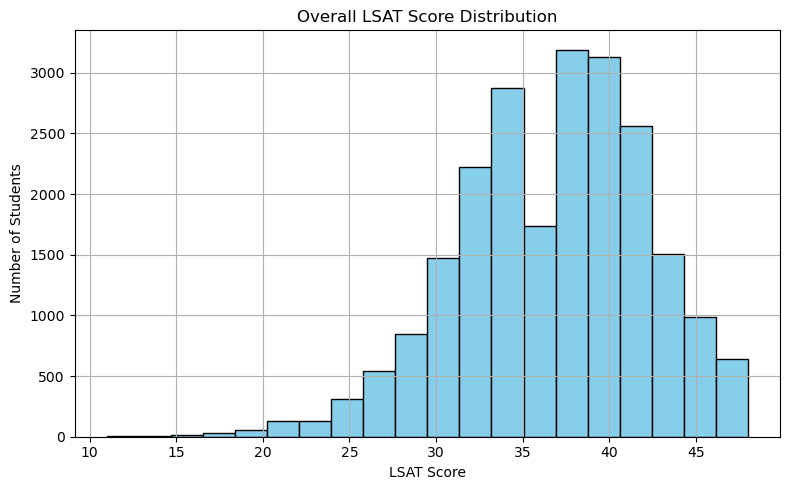

In [184]:
plt.figure(figsize=(8, 5))
df['lsat'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('LSAT Score')
plt.ylabel('Number of Students')
plt.title('Overall LSAT Score Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

In [185]:
print("\nAverage LSAT (Overall):")
print(df['lsat'].mean())


Average LSAT (Overall):
36.764439183454684


Now let us see how they relate to the passing of the exam

In [186]:
print("\nAverage LSAT by Pass/Fail:")
print(df.groupby('pass_bar')['lsat'].mean())


Average LSAT by Pass/Fail:
pass_bar
0    31.197001
1    37.070622
Name: lsat, dtype: float64


On average, students which passed the exam have a score around 37 and those who failed around 31. 

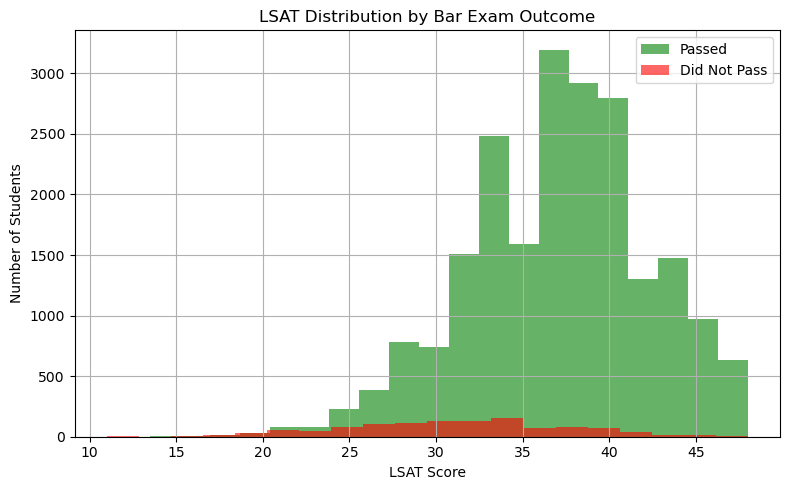

In [187]:
plt.figure(figsize=(8, 5))
df[df['pass_bar'] == True]['lsat'].hist(alpha=0.6, label='Passed', bins=20, color='green')
df[df['pass_bar'] == False]['lsat'].hist(alpha=0.6, label='Did Not Pass', bins=20, color='red')
plt.xlabel('LSAT Score')
plt.ylabel('Number of Students')
plt.title('LSAT Distribution by Bar Exam Outcome')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [188]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'race', 'cluster', 'lsat',
       'ugpa', 'zfygpa', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr',
       'fulltime', 'fam_inc', 'gender', 'parttime', 'male', 'race1', 'race2',
       'Dropout', 'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040',
       'indxgrp', 'indxgrp2'],
      dtype='object')

- **zfygpa**

In [189]:
df.zfygpa.isna().sum()

np.int64(981)

In this case we have null values. 

In [190]:
print("ZFYGPA Summary:")
print(df['zfygpa'].describe())

ZFYGPA Summary:
count    21406.000000
mean         0.086027
std          0.928604
min         -3.350000
25%         -0.560000
50%          0.080000
75%          0.740000
max          3.250000
Name: zfygpa, dtype: float64


In [191]:
#since this is the standard deviation we do not expect the values to reflect an actual gpa. 

print("\nAverage zfygpa (Overall):")
print(df['zfygpa'].mean())


Average zfygpa (Overall):
0.086026814911707


In [192]:
# filling the null values with the mean to not skew results and retain rows for analysis
mean_zfygpa = df['zfygpa'].mean()
df['zfygpa'] = df['zfygpa'].fillna(mean_zfygpa)

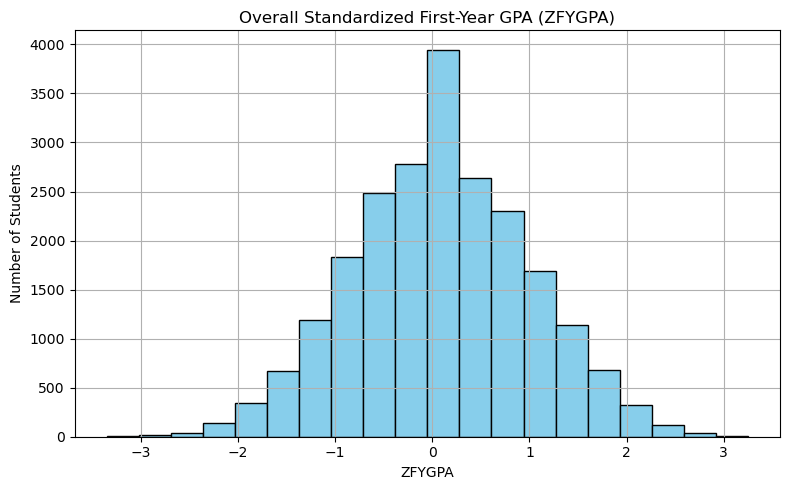

In [193]:
plt.figure(figsize=(8, 5))
df['zfygpa'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('ZFYGPA')
plt.ylabel('Number of Students')
plt.title('Overall Standardized First-Year GPA (ZFYGPA)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [194]:
print("\nAverage ZFYGPA by Pass/Fail:")
print(df.groupby('pass_bar')['zfygpa'].mean())


Average ZFYGPA by Pass/Fail:
pass_bar
0   -0.833646
1    0.136604
Name: zfygpa, dtype: float64


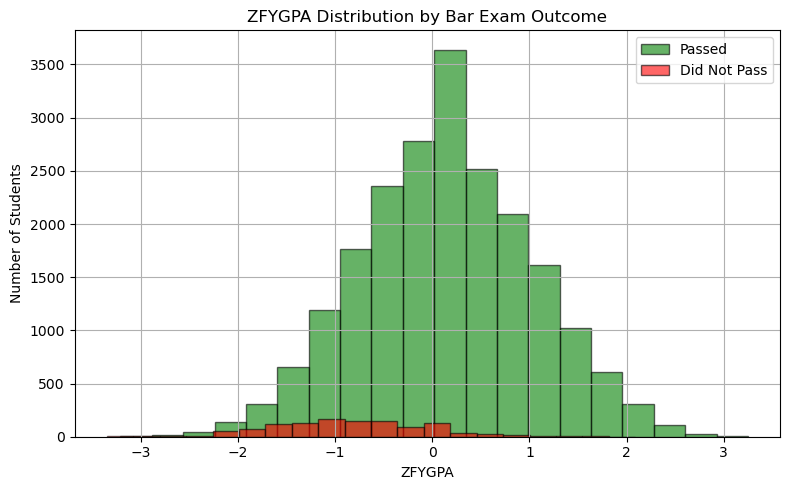

In [195]:
plt.figure(figsize=(8, 5))
df[df['pass_bar'] == True]['zfygpa'].hist(alpha=0.6, label='Passed', bins=20, color='green', edgecolor='black')
df[df['pass_bar'] == False]['zfygpa'].hist(alpha=0.6, label='Did Not Pass', bins=20, color='red', edgecolor='black')
plt.xlabel('ZFYGPA')
plt.ylabel('Number of Students')
plt.title('ZFYGPA Distribution by Bar Exam Outcome')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It is interesting to see how the distributions have their centers in different locations. This feature seems to be highly predictive. 

- **zgpa**

In [196]:
print("Missing zgpa values:", df['zgpa'].isnull().sum())

Missing zgpa values: 1287


In [197]:
mean_zgpa = df['zgpa'].mean()
df['zgpa'] = df['zgpa'].fillna(mean_zgpa)

In [198]:
print(f'The average zgpa (GPA in law school) is {mean_zgpa}')

The average zgpa (GPA in law school) is 0.008722748815165885


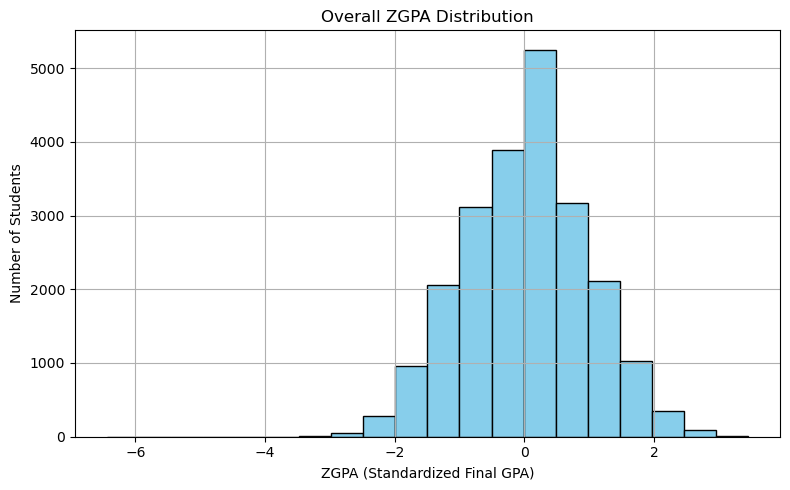

In [199]:
plt.figure(figsize=(8, 5))
df['zgpa'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('ZGPA (Standardized Final GPA)')
plt.ylabel('Number of Students')
plt.title('Overall ZGPA Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()


In [200]:
print("\nAverage ZGPA by Pass/Fail:")
print(df.groupby('pass_bar')['zgpa'].mean())


Average ZGPA by Pass/Fail:
pass_bar
0   -1.081353
1    0.068672
Name: zgpa, dtype: float64


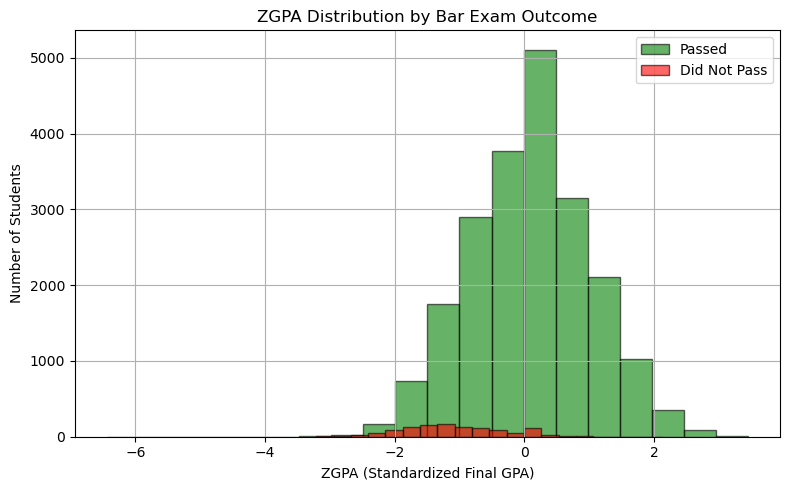

In [201]:
plt.figure(figsize=(8, 5))
df[df['pass_bar'] == True]['zgpa'].hist(alpha=0.6, label='Passed', bins=20, color='green', edgecolor='black')
df[df['pass_bar'] == False]['zgpa'].hist(alpha=0.6, label='Did Not Pass', bins=20, color='red', edgecolor='black')
plt.xlabel('ZGPA (Standardized Final GPA)')
plt.ylabel('Number of Students')
plt.title('ZGPA Distribution by Bar Exam Outcome')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now we can try to see if there is a way to combine these features into an "academic career" feature, which might or might not be used for prediction, we will see later. 

In [202]:
from sklearn.preprocessing import StandardScaler

academic_cols = df[['ugpa', 'lsat', 'zfygpa', 'zgpa']].copy()

academic_cols = academic_cols.fillna(academic_cols.mean())

scaler = StandardScaler()
academic_scaled = scaler.fit_transform(academic_cols)

df['academic_career'] = academic_scaled.mean(axis=1)

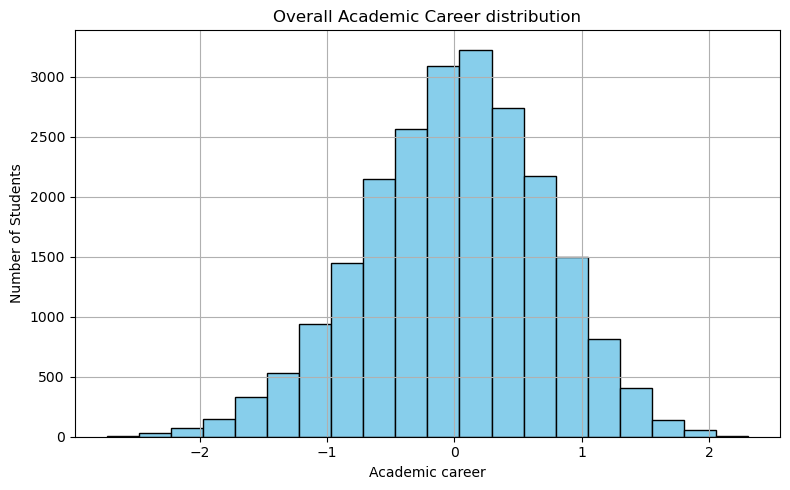

In [203]:
plt.figure(figsize=(8, 5))
df['academic_career'].hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Academic career')
plt.ylabel('Number of Students')
plt.title('Overall Academic Career distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

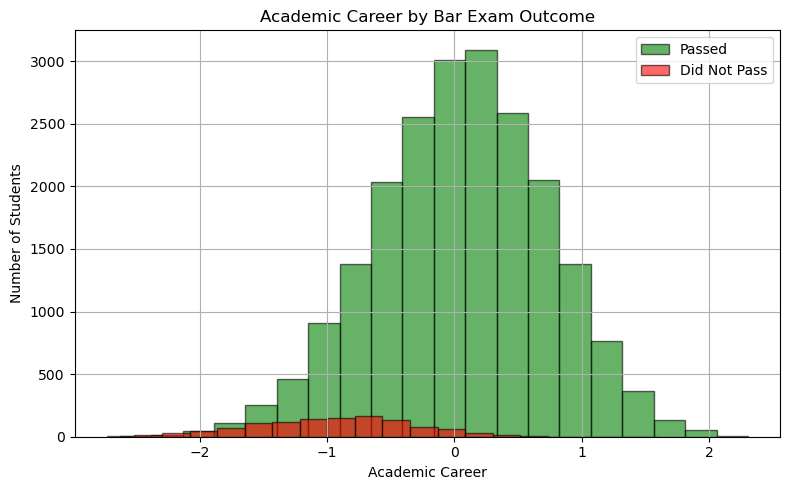

In [204]:
plt.figure(figsize=(8, 5))
df[df['pass_bar'] == True]['academic_career'].hist(alpha=0.6, label='Passed', bins=20, color='green', edgecolor='black')
df[df['pass_bar'] == False]['academic_career'].hist(alpha=0.6, label='Did Not Pass', bins=20, color='red', edgecolor='black')
plt.xlabel('Academic Career')
plt.ylabel('Number of Students')
plt.title('Academic Career by Bar Exam Outcome')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **time**

Then we can look at the *fulltime-part time* feature. These columns should contain opposite values and one of them should be dropped. 

In [205]:
time_cols = ['fulltime', 'parttime']
for col in time_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: fulltime
Unique values: [ 1.  2. nan]
Value counts:
 fulltime
1.0    20634
2.0     1720
NaN       33
Name: count, dtype: int64

Column: parttime
Unique values: [ 0.  1. nan]
Value counts:
 parttime
0.0    20634
1.0     1720
NaN       33
Name: count, dtype: int64


In [206]:
# drop fulltime cause it is not boolean
df.drop(columns=['fulltime'], inplace=True)

In [207]:
#drop the null values as they are a small percentage and we want to keep this feature
df.dropna(subset=['parttime'], inplace=True)

In [208]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'race', 'cluster', 'lsat',
       'ugpa', 'zfygpa', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr',
       'fam_inc', 'gender', 'parttime', 'male', 'race1', 'race2', 'Dropout',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'academic_career'],
      dtype='object')

*Dropout and grad*

Dropout is a flag that checks if a person has or not dropped out of school, while grad should tell if they have graduated or not. 

In [209]:
status_cols = ['Dropout', 'grad']
for col in status_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: Dropout
Unique values: ['NO' 'YES']
Value counts:
 Dropout
NO     22353
YES        1
Name: count, dtype: int64

Column: grad
Unique values: ['Y' 'X' nan 'O']
Value counts:
 grad
Y      22262
X         88
NaN        3
O          1
Name: count, dtype: int64


In [210]:
# since dropout has one singular no value and no null values it can be dropped as it will have no predictive value
df.drop(columns=['Dropout'], inplace=True)

The grad variable instead is more unexpected. The first hypothesis was that it would be a complement of Dropout, meaning if someone has graduated or not. But this is not the case. 

A possible meaning would be: 
- Y = yes, they graduated law school
- X = no, they did not, 
- O = other
and then null values. 

We should check if it holds any predictive value by checking the correlation with bar_pass

In [211]:
print(df.groupby('grad')['pass_bar'].value_counts(normalize=True))

grad  pass_bar
O     1           1.000000
X     1           0.727273
      0           0.272727
Y     1           0.948926
      0           0.051074
Name: proportion, dtype: float64


The O value, of course will have a correlation of 1 since there is only one value. 

We will keep the feature for now and remove it later if it skews predictions. So let's drop the three null values. 

In [212]:
df.dropna(subset=['grad'], inplace=True)

Interestingly, the only difference between bar_passed and pass_bar is the one single entry where the grad == O. This means that there might be some issue for that particular row. In this case therefore I prefer to drop it. 

In [213]:
df = df[df.grad != 'O']

We can also drop, then, bar_passed.

In [214]:
df.drop(columns=['bar_passed'], inplace=True)

In [215]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'race', 'cluster', 'lsat',
       'ugpa', 'zfygpa', 'grad', 'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr',
       'fam_inc', 'gender', 'parttime', 'male', 'race1', 'race2', 'pass_bar',
       'bar', 'tier', 'index6040', 'indxgrp', 'indxgrp2', 'academic_career'],
      dtype='object')

- **bar**

In [216]:
bar_cols = ['bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'bar']
for col in bar_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: bar1
Unique values: ['P' 'F']
Value counts:
 bar1
P    19796
F     2554
Name: count, dtype: int64

Column: bar1_yr
Unique values: [ 7.  2. nan  6.  1.]
Value counts:
 bar1_yr
7.0    19325
2.0     2817
6.0      152
NaN       39
1.0       17
Name: count, dtype: int64

Column: bar2
Unique values: ['P' 'F']
Value counts:
 bar2
P    21189
F     1161
Name: count, dtype: int64

Column: bar2_yr
Unique values: [94. 95. 96. nan 93.]
Value counts:
 bar2_yr
94.0    17532
95.0     4091
96.0      636
93.0       51
NaN        40
Name: count, dtype: int64

Column: bar
Unique values: ['a Passed 1st time' 'c Failed' 'b Passed 2nd time']
Value counts:
 bar
a Passed 1st time    19796
b Passed 2nd time     1393
c Failed              1161
Name: count, dtype: int64


These seem to represent the outcomes of the first and second attempt at the bar exam

In [217]:
df[bar_cols].isnull().sum()

bar1        0
bar1_yr    39
bar2        0
bar2_yr    40
bar         0
dtype: int64

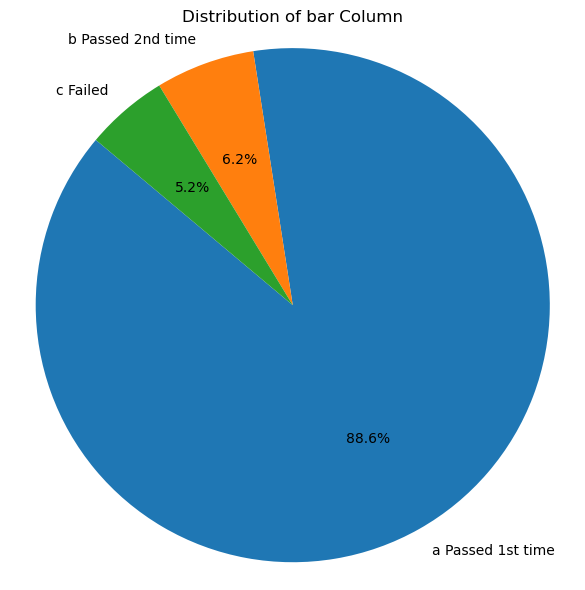

In [218]:
bar_counts = df['bar'].value_counts(dropna=False)

bar_labels = bar_counts.index.to_list()

# Plot
plt.figure(figsize=(6, 6))
plt.pie(bar_counts, labels=bar_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of bar Column')
plt.axis('equal')
plt.tight_layout()
plt.show()


bar1 and bar2 will be encodings of the bar column to know wether a student has passed the exam at the first or second try. 

In [219]:
print("bar1 vs pass_bar:")
print(df.groupby(['bar1', 'pass_bar']).size())

bar1 vs pass_bar:
bar1  pass_bar
F     0            1161
      1            1393
P     1           19796
dtype: int64


In [220]:
print("bar2 vs pass_bar:")
print(df.groupby(['bar2', 'pass_bar']).size())

bar2 vs pass_bar:
bar2  pass_bar
F     0            1161
P     1           21189
dtype: int64


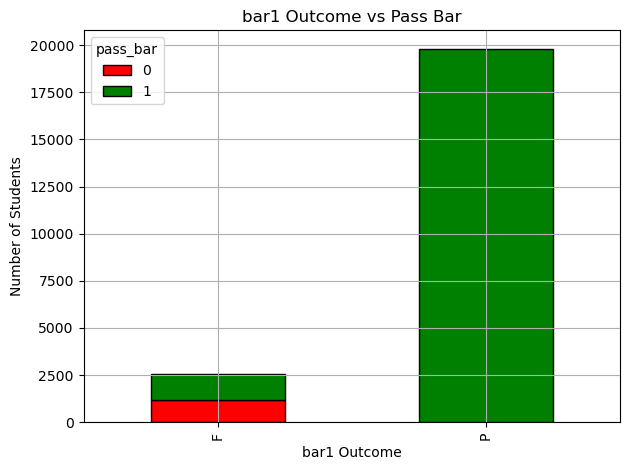

In [221]:
df.groupby(['bar1', 'pass_bar']).size().unstack().plot(
    kind='bar', stacked=True, color=['red', 'green'], edgecolor='black'
)
plt.title('bar1 Outcome vs Pass Bar')
plt.xlabel('bar1 Outcome')
plt.ylabel('Number of Students')
plt.grid(True)
plt.tight_layout()
plt.show()

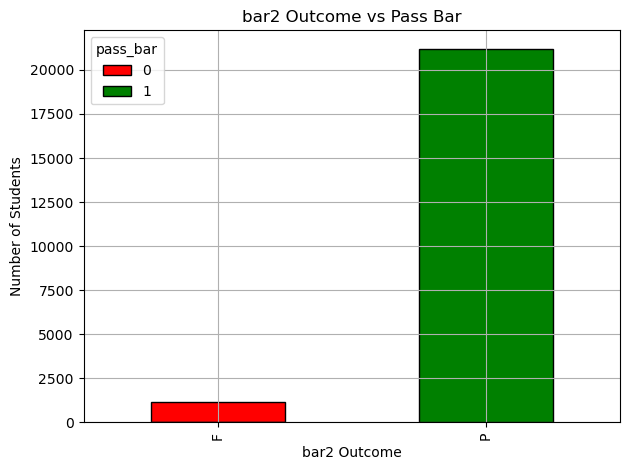

In [222]:
df.groupby(['bar2', 'pass_bar']).size().unstack().plot(
    kind='bar', stacked=True, color=['red', 'green'], edgecolor='black'
)
plt.title('bar2 Outcome vs Pass Bar')
plt.xlabel('bar2 Outcome')
plt.ylabel('Number of Students')
plt.grid(True)
plt.tight_layout()
plt.show()

Let us explain these results: 
- 19796 students have passed the bar exam on their first try
- 1393 have passed at the second try (19796+1393 = 21189)
- 1161 students do not pass the exam at all

This is in line with the distribution of the pass_bar variable, and the bar2 column encodes the exact same values as the pass_bar. This means that it should be dropped as the model will most probably rely singularly on this feature to predict. 

In [223]:
print("\nPass rate by bar1_yr:")
print(df.groupby('bar1_yr')['pass_bar'].mean() * 100)

print("\nPass rate by bar2_yr:")
print(df.groupby('bar2_yr')['pass_bar'].mean() * 100)


Pass rate by bar1_yr:
bar1_yr
1.0    88.235294
2.0    90.557330
6.0    92.763158
7.0    95.441138
Name: pass_bar, dtype: float64

Pass rate by bar2_yr:
bar2_yr
93.0    96.078431
94.0    96.298198
95.0    89.806893
96.0    85.534591
Name: pass_bar, dtype: float64


Also in this case, the years do not provide any readable information about when these years actually where, as they are encoded numerically in some way. Still, we keep this feature, so we fill the nulls with the mode. 

In [224]:
bar1_mode = df['bar1_yr'].mode()[0]
df['bar1_yr'] = df['bar1_yr'].fillna(bar1_mode)

bar2_mode = df['bar2_yr'].mode()[0]
df['bar2_yr'] = df['bar2_yr'].fillna(bar2_mode)

- **family income**

In [225]:
df.fam_inc.value_counts().isna().sum()

np.int64(0)

In [226]:
df.fam_inc.value_counts()

fam_inc
4.0    9748
3.0    7880
2.0    2179
5.0    1813
1.0     452
Name: count, dtype: int64

It looks like the family income is ranked on a tier list. We would assume that, given the elitist nature of law school and of the law profession, the number 5 represents the highest income families, while the 1 represents the low income. Most people come from groups 3 and 4. 

In [227]:
print("\nAverage Family Income (Overall):")
print(df['fam_inc'].mean())


Average Family Income (Overall):
3.466246828561073


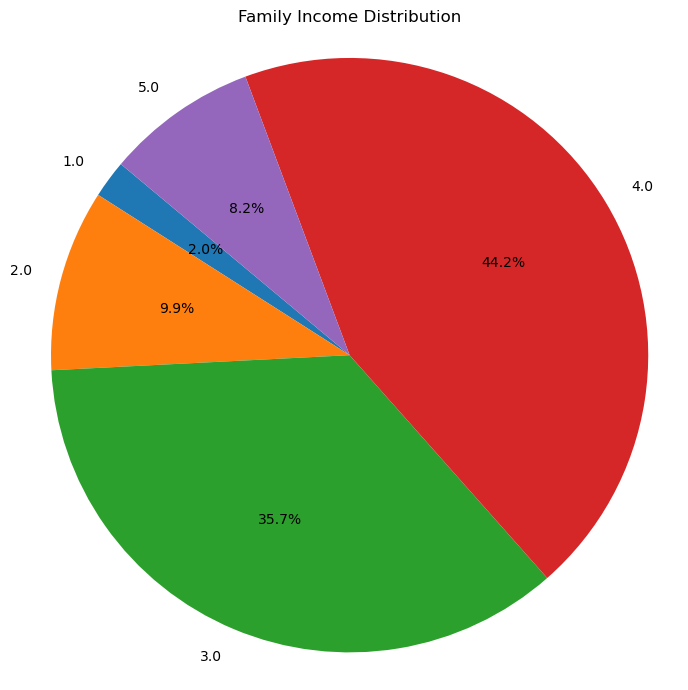

In [228]:
income_counts = df['fam_inc'].value_counts().sort_index()

# 4. Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(income_counts, labels=income_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Family Income Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()


Expectedly, most students come from a high income family.

In [229]:
print("\nAverage Family Income by Pass/Fail:")
print(df.groupby('pass_bar')['fam_inc'].mean())


Average Family Income by Pass/Fail:
pass_bar
0    3.170325
1    3.482348
Name: fam_inc, dtype: float64


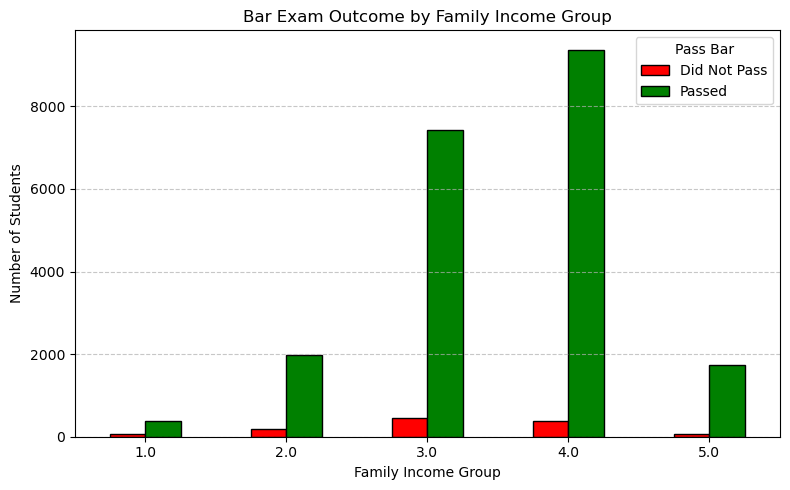

In [230]:
income_pass_counts = df.groupby(['fam_inc', 'pass_bar']).size().unstack(fill_value=0)

# 4. Plot grouped bar chart
income_pass_counts.plot(
    kind='bar',
    figsize=(8, 5),
    color=['red', 'green'],
    edgecolor='black'
)

# 5. Formatting
plt.title('Bar Exam Outcome by Family Income Group')
plt.xlabel('Family Income Group')
plt.ylabel('Number of Students')
plt.xticks(rotation=0)
plt.legend(['Did Not Pass', 'Passed'], title='Pass Bar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Interestingly, wealthier people seem to pass the bar exam more than the low income. This could be a source of bias, and therefore we would like to investigate it further. 

In [231]:
income_totals = df['fam_inc'].value_counts().sort_index()
income_passed = df[df['pass_bar'] == True]['fam_inc'].value_counts().sort_index()

# Calculate pass rate
income_pass_rate = (income_passed / income_totals) * 100

# Combine into a summary DataFrame
income_summary = pd.DataFrame({
    'Total Students': income_totals,
    'Passed': income_passed,
    'Pass Rate (%)': income_pass_rate
}).fillna(0)

# Display sorted by pass rate
print(income_summary.sort_values(by='Pass Rate (%)', ascending=False))

         Total Students  Passed  Pass Rate (%)
fam_inc                                       
5.0                1813    1745      96.249311
4.0                9748    9374      96.163316
3.0                7880    7436      94.365482
2.0                2179    1989      91.280404
1.0                 452     389      86.061947


Interestingly, the distributions do not seem that skewed, besides for group 1. 

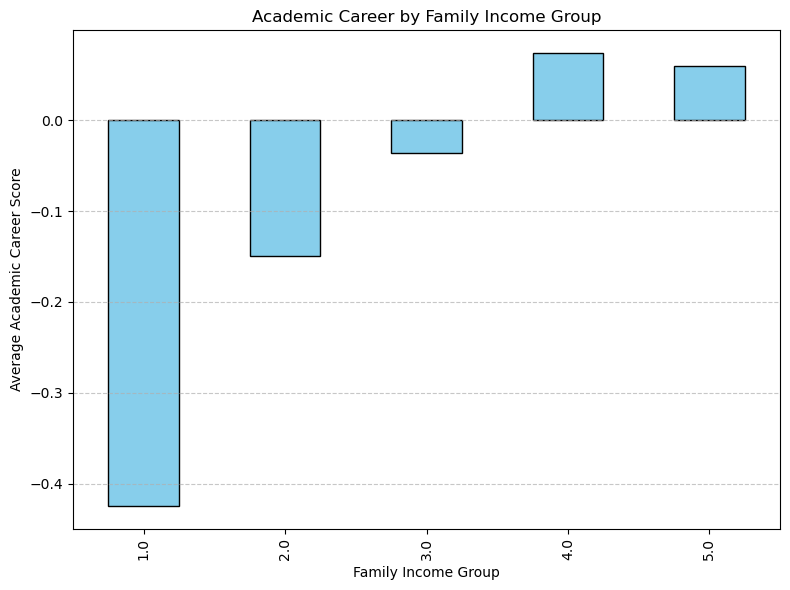

In [232]:
plt.figure(figsize=(8, 6))
df.groupby('fam_inc')['academic_career'].mean().plot(
    kind='bar', color='skyblue', edgecolor='black'
)
plt.xlabel('Family Income Group')
plt.ylabel('Average Academic Career Score')
plt.title('Academic Career by Family Income Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



It seems like people with a lower income have bad grades, while the ones with a high income have better careers. This might be the reason why they do not pass the bar exam, but it could also reflect a highly elitist culture which is more lenient towards people who come from money. 

- **tier**

In [233]:
df.tier.value_counts()

tier
3.0    7977
4.0    6069
5.0    3882
6.0    2045
2.0    1690
1.0     591
Name: count, dtype: int64

In [234]:
df.tier.isnull().sum()

np.int64(96)

In [235]:
df['tier'] = df['tier'].fillna(df['tier'].mode()[0])

Tier distribution:
tier
1.0     591
2.0    1690
3.0    8073
4.0    6069
5.0    3882
6.0    2045
Name: count, dtype: int64


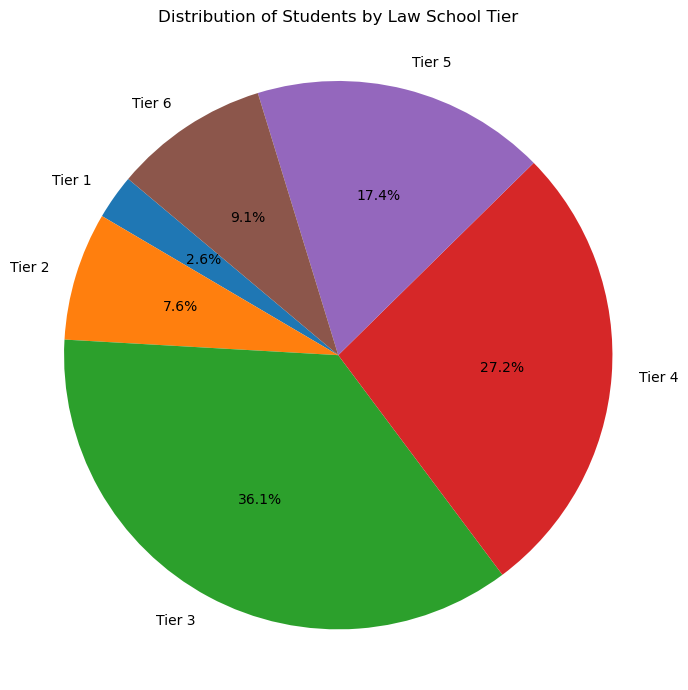

In [236]:
# Value counts of filled tier
tier_counts = df['tier'].value_counts().sort_index()

# Print counts
print("Tier distribution:")
print(tier_counts)

# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    tier_counts,
    labels=[f'Tier {int(t)}' for t in tier_counts.index],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Distribution of Students by Law School Tier')
plt.axis('equal')
plt.tight_layout()
plt.show()


The majority of the schools are considered tier 3, 4, 5. 

In [237]:
tier_totals = df['tier'].value_counts().sort_index()
tier_passed = df[df['pass_bar'] == True]['tier'].value_counts().sort_index()

# Calculate pass rate per tier
tier_pass_rate = (tier_passed / tier_totals) * 100

# Combine into a summary table
tier_summary = pd.DataFrame({
    'Total Students': tier_totals,
    'Passed': tier_passed,
    'Pass Rate (%)': tier_pass_rate
}).fillna(0)

tier_summary

,Total Students,Passed,Pass Rate (%)
tier,,,
1.0,591,460,77.834179
2.0,1690,1550,91.715976
3.0,8073,7640,94.636442
4.0,6069,5827,96.012523
5.0,3882,3703,95.388975
6.0,2045,2009,98.239609


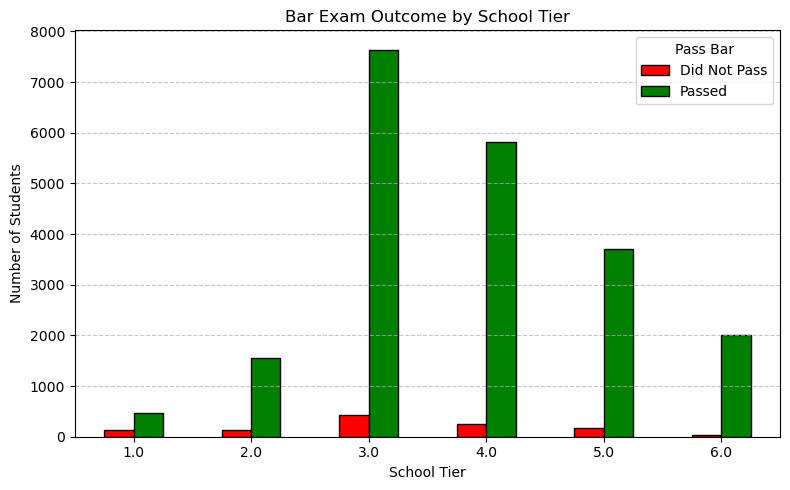

In [238]:
tier_pass_counts = df.groupby(['tier', 'pass_bar']).size().unstack(fill_value=0)

# 4. Plot grouped bar chart
tier_pass_counts.plot(
    kind='bar',
    figsize=(8, 5),
    color=['red', 'green'],
    edgecolor='black'
)

# 5. Formatting
plt.title('Bar Exam Outcome by School Tier')
plt.xlabel('School Tier')
plt.ylabel('Number of Students')
plt.xticks(rotation=0)
plt.legend(['Did Not Pass', 'Passed'], title='Pass Bar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

People coming from a tier 6 school (most selective) tend to pass more the bar exam. This needs to be investigated because it could be a potential source of bias. 

In [239]:
# Count total and passed students per tier
tier_totals = df['tier'].value_counts().sort_index()
tier_passed = df[df['pass_bar'] == True]['tier'].value_counts().sort_index()

# Calculate pass rate as percentage
tier_pass_rate = (tier_passed / tier_totals) * 100

# Combine into DataFrame
tier_summary = pd.DataFrame({
    'Total Students': tier_totals,
    'Passed': tier_passed,
    'Pass Rate (%)': tier_pass_rate
}).fillna(0)

# Show the result
print(tier_summary)


      Total Students  Passed  Pass Rate (%)
tier                                       
1.0              591     460      77.834179
2.0             1690    1550      91.715976
3.0             8073    7640      94.636442
4.0             6069    5827      96.012523
5.0             3882    3703      95.388975
6.0             2045    2009      98.239609


There is a significant gap between tier 1 and all the other tiers. This might lead to bias and needs to be checked. 

- **deciles**

This column represents in which percentage the students are located in terms of academic career during law school. So we need to check for their values and their correlation with gpa 

In [240]:
decile_cols = ['decile1b', 'decile1','decile3']
for col in decile_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))
    print(f'Number of null values: {df[col].isnull().sum()}')


Column: decile1b
Unique values: [10.  5.  3.  7.  9.  4.  2.  6. nan  1.  8.]
Value counts:
 decile1b
5.0     2117
7.0     2102
9.0     2098
6.0     2098
8.0     2091
3.0     2088
4.0     2078
10.0    2064
2.0     2054
1.0     1977
NaN     1583
Name: count, dtype: int64
Number of null values: 1583

Column: decile1
Unique values: [10.  5.  3.  7.  9.  4.  6. nan  1.  8.  2.]
Value counts:
 decile1
5.0     2250
7.0     2249
9.0     2248
6.0     2239
8.0     2239
10.0    2216
4.0     2196
3.0     2144
2.0     1994
1.0     1501
NaN     1074
Name: count, dtype: int64
Number of null values: 1074

Column: decile3
Unique values: [10.  4.  2.  8.  5.  7.  6.  3. nan  1.  9.]
Value counts:
 decile3
5.0     2118
4.0     2106
6.0     2104
9.0     2103
7.0     2102
3.0     2091
8.0     2076
10.0    2052
2.0     2046
1.0     1969
NaN     1583
Name: count, dtype: int64
Number of null values: 1583


They all contain a lot of null values. 

In [241]:
df['decile1'] = df['decile1'].fillna(df['decile1'].mode()[0])
df['decile1b'] = df['decile1b'].fillna(df['decile1b'].mode()[0])
df['decile3'] = df['decile3'].fillna(df['decile3'].mode()[0])

In [242]:
print(df[['decile1', 'decile1b', 'decile3']].corr())

           decile1  decile1b   decile3
decile1   1.000000  0.976776  0.850481
decile1b  0.976776  1.000000  0.864331
decile3   0.850481  0.864331  1.000000


Decile 1 and Decile 1b are almost identical and extremely highly correlated. Our guess is that they encode the same information but adapted a little bit. 

Since they should represent the rank in law school, we can check how they correlate to the law school gpa columns

In [243]:
df_dec = df[['decile1b', 'decile1', 'zfygpa', 'decile3', 'zgpa', 'ugpa', 'lsat']]
print(df_dec.corr())

          decile1b   decile1    zfygpa   decile3      zgpa      ugpa      lsat
decile1b  1.000000  0.976776  0.954891  0.864331  0.851469  0.163749  0.259667
decile1   0.976776  1.000000  0.970982  0.850481  0.839126  0.159280  0.255108
zfygpa    0.954891  0.970982  1.000000  0.837626  0.856105  0.169130  0.274587
decile3   0.864331  0.850481  0.837626  1.000000  0.969197  0.207925  0.271551
zgpa      0.851469  0.839126  0.856105  0.969197  1.000000  0.217465  0.285542
ugpa      0.163749  0.159280  0.169130  0.207925  0.217465  1.000000  0.243846
lsat      0.259667  0.255108  0.274587  0.271551  0.285542  0.243846  1.000000


Okay, ugpa and lsat are not correlated at all to these variables, so it makes no sense to include them. While decile1 is correlated to the first year academic career, while decile3 to the overall career in law school. 

Plotting distributions

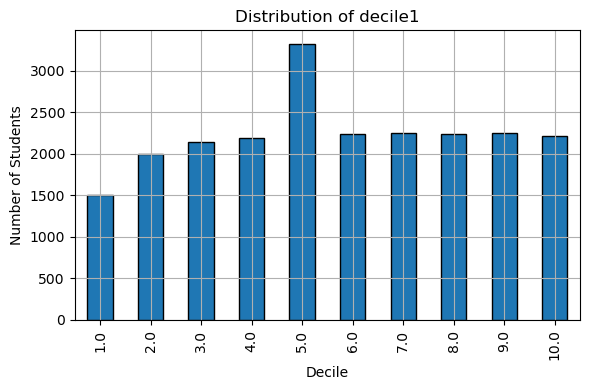

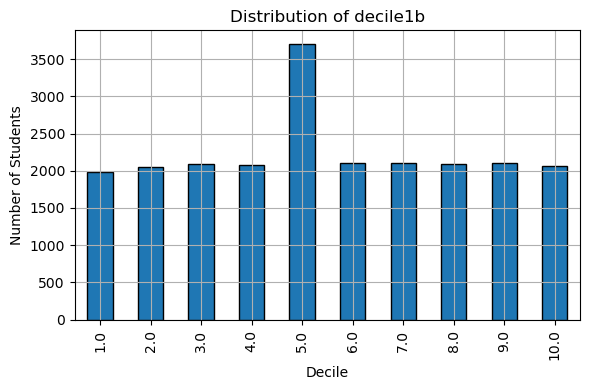

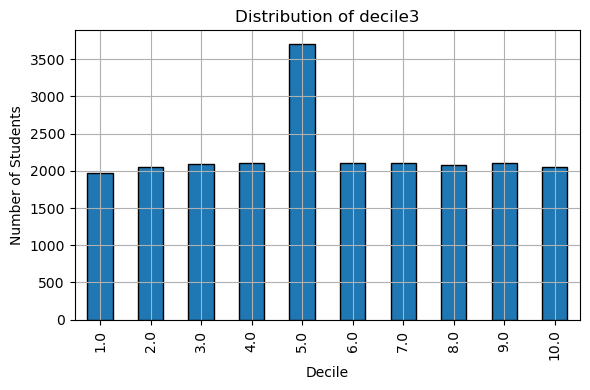

In [244]:
for col in ['decile1', 'decile1b', 'decile3']:
    plt.figure(figsize=(6, 4))
    df[col].value_counts().sort_index().plot(kind='bar', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Decile')
    plt.ylabel('Number of Students')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Most people seem to be located in the 5th decile, so in the middle of the dataset. 

In [245]:
for col in ['decile1', 'decile1b', 'decile3']:
    pass_rate = df.groupby(col)['pass_bar'].mean() * 100
    print(f"\nPass rate by {col}:")
    print(pass_rate.sort_index())


Pass rate by decile1:
decile1
1.0     77.148568
2.0     87.612839
3.0     92.024254
4.0     94.581056
5.0     95.517449
6.0     97.945511
7.0     98.310360
8.0     98.883430
9.0     99.288256
10.0    99.684116
Name: pass_bar, dtype: float64

Pass rate by decile1b:
decile1b
1.0     78.806272
2.0     89.191821
3.0     92.624521
4.0     95.332050
5.0     95.837838
6.0     98.045758
7.0     98.477640
8.0     98.947872
9.0     99.332698
10.0    99.709302
Name: pass_bar, dtype: float64

Pass rate by decile3:
decile3
1.0     75.317420
2.0     88.954057
3.0     93.256815
4.0     95.916429
5.0     96.001081
6.0     98.336502
7.0     99.000951
8.0     99.566474
9.0     99.762244
10.0    99.805068
Name: pass_bar, dtype: float64


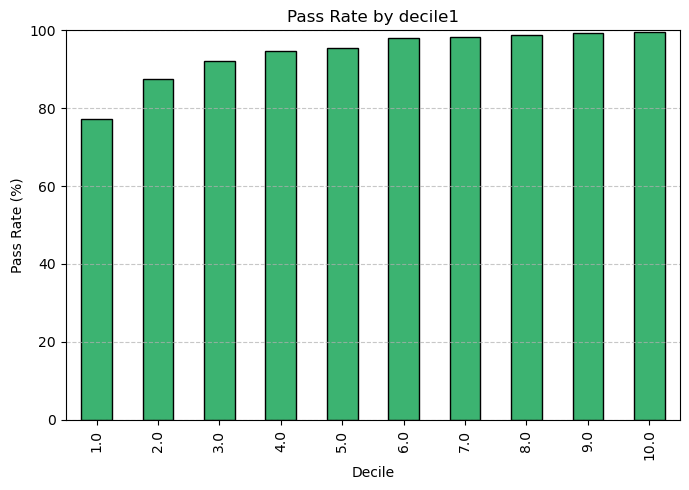

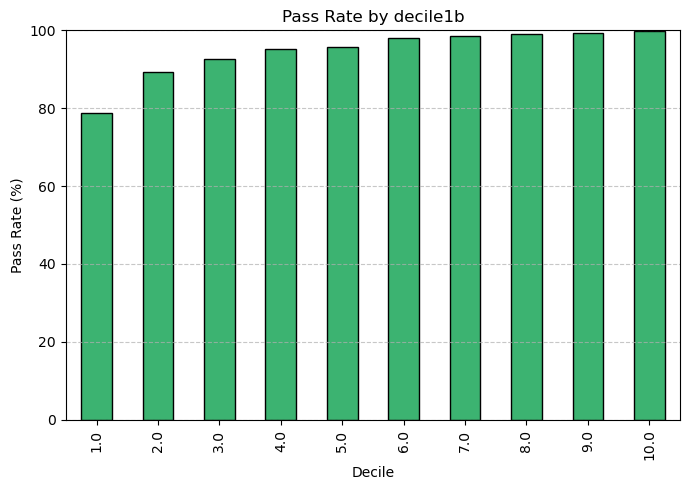

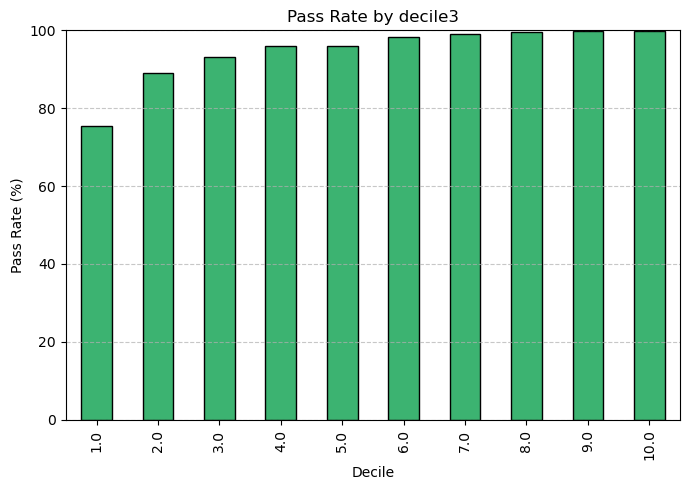

In [246]:
for col in ['decile1', 'decile1b', 'decile3']:
    # Group by decile and calculate pass rate
    pass_rate = df.groupby(col)['pass_bar'].mean() * 100

    # Plot
    plt.figure(figsize=(7, 5))
    pass_rate.sort_index().plot(kind='bar', color='mediumseagreen', edgecolor='black')
    plt.title(f'Pass Rate by {col}')
    plt.xlabel('Decile')
    plt.ylabel('Pass Rate (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

<Figure size 800x500 with 0 Axes>

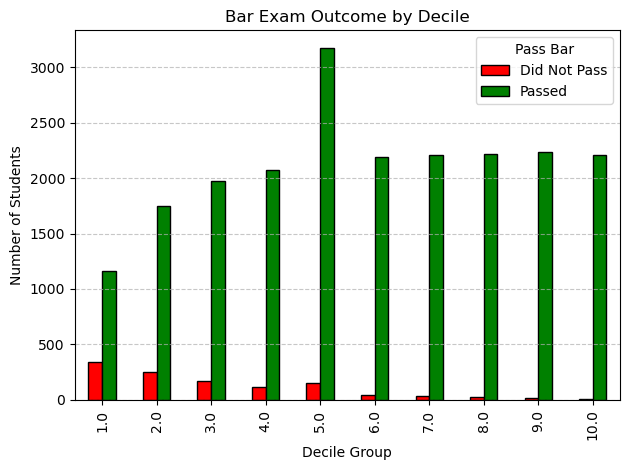

In [247]:
decile_counts = df.groupby(['decile1', 'pass_bar']).size().unstack(fill_value=0).sort_index()

# Plot grouped bar chart
plt.figure(figsize=(8, 5))
decile_counts.plot(
    kind='bar',
    stacked=False,
    color=['red', 'green'],
    edgecolor='black'
)

# Formatting
plt.title('Bar Exam Outcome by Decile')
plt.xlabel('Decile Group')
plt.ylabel('Number of Students')
plt.legend(title='Pass Bar', labels=['Did Not Pass', 'Passed'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 800x500 with 0 Axes>

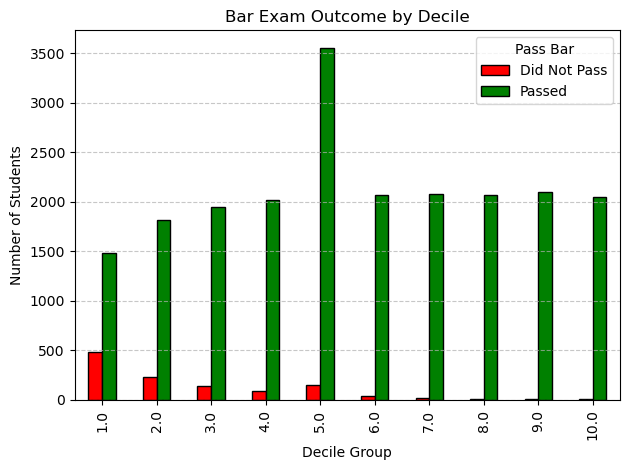

In [248]:
decile_counts = df.groupby(['decile3', 'pass_bar']).size().unstack(fill_value=0).sort_index()

# Plot grouped bar chart
plt.figure(figsize=(8, 5))
decile_counts.plot(
    kind='bar',
    stacked=False,
    color=['red', 'green'],
    edgecolor='black'
)

# Formatting
plt.title('Bar Exam Outcome by Decile')
plt.xlabel('Decile Group')
plt.ylabel('Number of Students')
plt.legend(title='Pass Bar', labels=['Did Not Pass', 'Passed'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Of course, people with good academic careers (10th decile) are more likely to pass the bar exam

In [249]:
# drop decile1b
df.drop(columns=['decile1b'], inplace=True)

- **cluster**

This variable is possibly the most cryptic, as it holds no real meaning. 

In [250]:
df.cluster.value_counts()

cluster
3.0    7977
1.0    6069
4.0    3882
5.0    2045
2.0    1690
6.0     591
Name: count, dtype: int64

In [251]:
df.cluster.isnull().sum()

np.int64(96)

In [252]:
df[['cluster', 'pass_bar']].corr()

,cluster,pass_bar
cluster,1.000000,-0.033904
pass_bar,-0.033904,1.000000


There is no correlation, so the column can be safely dropped

In [253]:
df.drop(columns=['cluster'], inplace=True)

- **indexes**

In [254]:
df.columns

Index(['decile3', 'ID', 'decile1', 'race', 'lsat', 'ugpa', 'zfygpa', 'grad',
       'zgpa', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'fam_inc', 'gender',
       'parttime', 'male', 'race1', 'race2', 'pass_bar', 'bar', 'tier',
       'index6040', 'indxgrp', 'indxgrp2', 'academic_career'],
      dtype='object')

In [255]:
index_cols = ['index6040', 'indxgrp', 'indxgrp2']
for col in index_cols:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())
    print("Value counts:\n", df[col].value_counts(dropna=False))


Column: index6040
Unique values: [886.842082  649.999987  760.526298  ... 590.526298  686.842082
 467.8947235]
Value counts:
 index6040
756.315771    168
766.315771    160
730.526298    157
797.894717    154
803.684190    152
             ... 
373.684203      1
452.631568      1
539.473670      1
515.789460      1
479.473672      1
Name: count, Length: 1180, dtype: int64

Column: indxgrp
Unique values: ['g 700+' 'f 640-700' 'e 580-640' 'd 520-580' 'c 460-520' 'b 400-460'
 'a under 400']
Value counts:
 indxgrp
g 700+         15236
f 640-700       3772
e 580-640       1940
d 520-580        828
c 460-520        406
b 400-460        129
a under 400       39
Name: count, dtype: int64

Column: indxgrp2
Unique values: ['i 820+' 'f 640-700' 'h 760-820' 'g 700-760' 'e 580-640' 'd 520-580'
 'c 460-520' 'b 400-460' 'a under 400']
Value counts:
 indxgrp2
i 820+         5221
g 700-760      5127
h 760-820      4888
f 640-700      3772
e 580-640      1940
d 520-580       828
c 460-520       406
b 40

In [256]:
df['indxgrp'] = df['indxgrp'].fillna(df['indxgrp'].mode()[0])
df['indxgrp2'] = df['indxgrp2'].fillna(df['indxgrp2'].mode()[0])
df['index6040'] = df['index6040'].fillna(df['index6040'].median())

indxgrp

In [257]:
from sklearn.calibration import LabelEncoder


le = LabelEncoder()
df['indxgrp_encoded'] = le.fit_transform(df['indxgrp'])
df['indxgrp_encoded'].value_counts()

indxgrp_encoded
6    15236
5     3772
4     1940
3      828
2      406
1      129
0       39
Name: count, dtype: int64

In [258]:
correlation_matrix = df[['indxgrp_encoded', 'pass_bar']].corr()
correlation_matrix

,indxgrp_encoded,pass_bar
indxgrp_encoded,1.000000,0.291698
pass_bar,0.291698,1.000000


The correlation is very low so it can be dropped. 

In [259]:
df.drop(columns=['indxgrp_encoded', 'indxgrp'], inplace=True)

indxgrp2

In [260]:
from sklearn.calibration import LabelEncoder


le = LabelEncoder()
df['indxgrp2_encoded'] = le.fit_transform(df['indxgrp2'])
df['indxgrp2_encoded'].value_counts()

indxgrp2_encoded
8    5221
6    5127
7    4888
5    3772
4    1940
3     828
2     406
1     129
0      39
Name: count, dtype: int64

In [261]:
correlation_matrix = df[['indxgrp2_encoded', 'pass_bar']].corr()
correlation_matrix

,indxgrp2_encoded,pass_bar
indxgrp2_encoded,1.000000,0.264042
pass_bar,0.264042,1.000000


In [262]:
# no correlation so drop
df.drop(columns=['indxgrp2_encoded', 'indxgrp2'], inplace=True)

index6040

In [263]:
correlation_matrix = df[['index6040', 'pass_bar']].corr()
correlation_matrix

,index6040,pass_bar
index6040,1.000000,0.254424
pass_bar,0.254424,1.000000


In [264]:
# no correlation so drop
df.drop(columns=['index6040'], inplace=True)

### adjusting types to have numerical columns for analysis and encode when necessary

In [265]:
df.dtypes

decile3            float64
ID                   int64
decile1            float64
race               float64
lsat               float64
ugpa               float64
zfygpa             float64
grad                object
zgpa               float64
bar1                object
bar1_yr            float64
bar2                object
bar2_yr            float64
fam_inc            float64
gender              object
parttime           float64
male               float64
race1               object
race2               object
pass_bar             int64
bar                 object
tier               float64
academic_career    float64
dtype: object

In [266]:
df.pass_bar = df.pass_bar.astype(int)

In [267]:
# Encode grad: 1 = 'Y' (graduated), 0 = everything else
df['grad'] = df['grad'].apply(lambda x: 1 if x == 'Y' else 0)

# Encode bar1 and bar2: 1 = Passed, 0 = Failed
df['bar1'] = df['bar1'].apply(lambda x: 1 if x == 'P' else 0)
df['bar2'] = df['bar2'].apply(lambda x: 1 if x == 'P' else 0)

# NOTE
The not encoded columns I don't know how to treat them so please modify as needed 

## Categories that might be biased: 

- gender (actually not but always needs to be checked)
- tier
- race
- income

## Other things to note
- during prediction, the column bar will encode the information so the model will overrely on it

# Bias Detection
### 1. AI Fairness 360

In [269]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

### 1.1. Detect Gender Bias w.r.t. passed bar exam

In [270]:
df["gender"].unique()

array(['female', 'male'], dtype=object)

In [ ]:
df_clean = df.dropna().copy()

df_clean['gender'] = df_clean['gender'].str.lower().str.strip()
df_clean['gender_bin'] = df_clean['gender'].apply(lambda x: 1 if x == 'male' else 0)

df_clean = df_clean.select_dtypes(include=[np.number])

required = ['pass_bar', 'gender_bin']
for col in required:
    if col not in df_clean.columns:
        raise ValueError(f"Missing required column: {col}")

aif_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df_clean,
    label_names=['pass_bar'],
    protected_attribute_names=['gender_bin']
)


In [ ]:
metric = BinaryLabelDatasetMetric(
    aif_data,
    privileged_groups=[{'gender_bin': 1}],
    unprivileged_groups=[{'gender_bin': 0}]
)

print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())


Disparate Impact: 0.9899963391029994
Statistical Parity Difference: -0.009529297140110748


- **No gender bias detected as the treshhold for DI is 1 and for SPD 0**

### 1.2. Detect Race Bias w.r.t. passed bar exam 

In [273]:
df["race1"].unique()

array(['white', 'hisp', 'asian', 'black', 'other'], dtype=object)

In [ ]:
race_groups = ['black', 'hisp', 'asian', 'other']
results = {}

df_clean['race1'] = df['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar', 'race_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar', 'race_bin'])

    if df_numeric['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one race_bin present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar'],
        protected_attribute_names=['race_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'race_bin': 1}],  # white
        unprivileged_groups=[{'race_bin': 0}]  # current group
    )

    results[group] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }



/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_48623/388541099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')


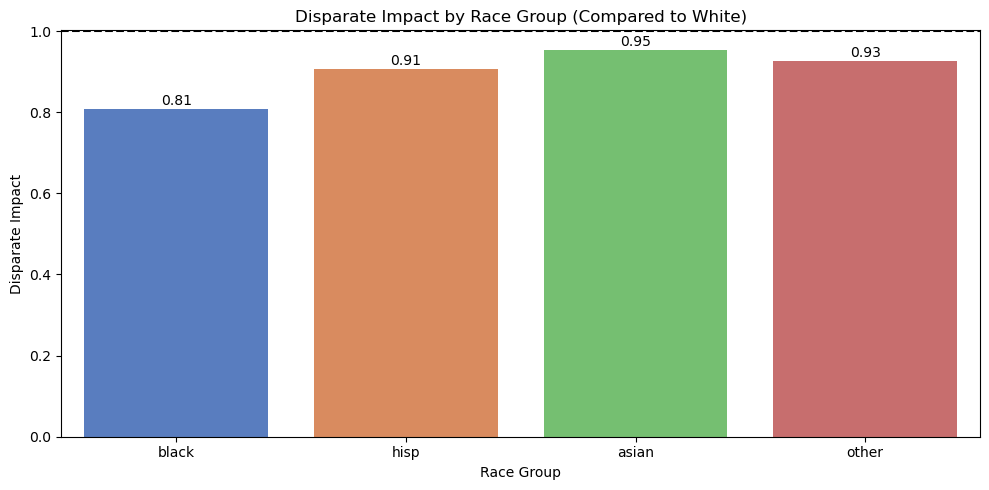

In [ ]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Race'})

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Race', y='Disparate Impact', palette='muted')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Race Group (Compared to White)")
plt.ylabel("Disparate Impact")
plt.xlabel("Race Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


- **A value of 1.0 indicates parity with the reference group, while values below 1.0 suggest potential adverse impact. Black applicants show the lowest disparate impact at 0.81, suggesting potential bias towards this group. Hispanic, Asian, and Other groups exhibit slightly lower chances of passing compared to White applicants, but all remain closer to 1** 

### 1.3. Family Income w.r.t Passed bar exam

In [276]:
df['fam_inc'].unique()

array([ 5.,  4.,  1.,  3.,  2., nan])

- 1: low income
- 5: high income

In [ ]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = {}

df_clean = df_clean.dropna(subset=['fam_inc'])

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar', 'income_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar', 'income_bin'])

    if df_numeric['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar'],
        protected_attribute_names=['income_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'income_bin': 1}],  # high income (5)
        unprivileged_groups=[{'income_bin': 0}]  # current group
    )

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }



/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_48623/1763820517.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')


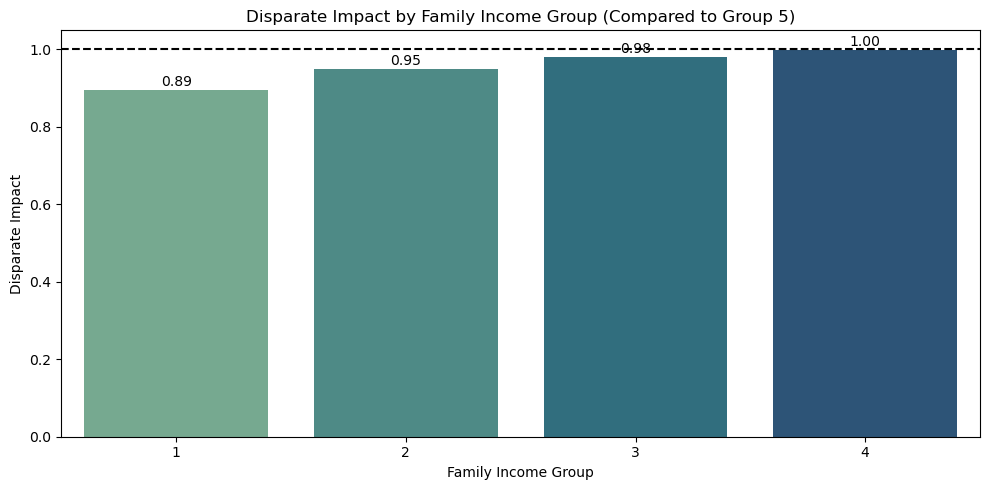

In [ ]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Income Group'})
results_df = results_df.sort_values(by='Income Group')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Income Group', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Family Income Group (Compared to Group 5)")
plt.ylabel("Disparate Impact")
plt.xlabel("Family Income Group")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


- **This plot displays the disparate impact of bar exam outcomes across family income groups, with Group 5 (highest income) serving as the privileged reference group. Group 1 (lowest income) shows the greatest disparity at 0.89, suggesting a moderately reduced likelihood of passing the bar exam relative to higher-income peers. The disparity decreases progressively with income level, reaching parity (1.00) for Group 4.**

### 1.4. Tier w.r.t. passed bar exam

- tier 6: most selective school

In [279]:
df['tier'].unique()

array([4., 2., 3., 5., 1., 6.])

In [ ]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
results = {}

df_clean = df_clean.dropna(subset=['tier'])

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    df_numeric = df_temp.select_dtypes(include=[np.number])
    for col in ['pass_bar', 'tier_bin']:
        if col not in df_numeric.columns:
            df_numeric[col] = df_temp[col]

    df_numeric = df_numeric.dropna(subset=['pass_bar', 'tier_bin'])

    if df_numeric['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df_numeric,
        label_names=['pass_bar'],
        protected_attribute_names=['tier_bin']
    )

    metric = BinaryLabelDatasetMetric(
        dataset,
        privileged_groups=[{'tier_bin': 1}],   # Tier 6 (privileged)
        unprivileged_groups=[{'tier_bin': 0}]  # Current tier (1–5)
    )

    results[int(group)] = {
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Difference': metric.statistical_parity_difference()
    }



/var/folders/8m/vc39dsjs42xc715q8xwxx4z80000gn/T/ipykernel_48623/2630388145.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')


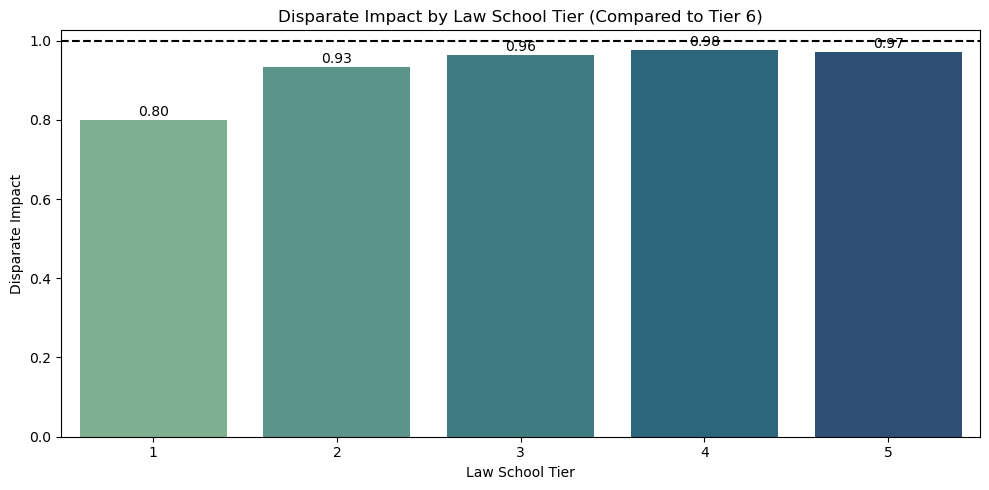

In [ ]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Tier'})
results_df = results_df.sort_values(by='Tier')

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Tier', y='Disparate Impact', palette='crest')
plt.axhline(1.0, linestyle='--', color='black')
plt.title("Disparate Impact by Law School Tier (Compared to Tier 6)")
plt.ylabel("Disparate Impact")
plt.xlabel("Law School Tier")

for idx, row in results_df.iterrows():
    plt.text(idx, row['Disparate Impact'] + 0.01, f"{row['Disparate Impact']:.2f}", ha='center')

plt.tight_layout()
plt.show()


- **This plot displays the disparate impact in bar exam passage rates by law school tier, using Tier 6 (top-ranked schools) as the privileged reference group. Tier 1 shows a disparate impact value of 0.80, indicating significantly lower success rates compared to Tier 6. Tiers 2 through 5 demonstrate progressively less disparity, with values ranging from 0.93 to 0.98, approaching parity with Tier 6.**

### 2. Wasserstein Distance
Wasserstein distance measures the minimum "cost" of transforming one probability distribution into another. A higher cost might indicate bias

We decided also to measure Wasserstein Distance as in the article mentioned below it is suggested that: Disparate Impact might indicate fairness, but Wasserstein Distance reveals a clear difference in score distributions across groups — indicating hidden bias

The authors of it recommend using Wasserstein distance along traditional fairness metrics as DI

**Link to article:** https://securedata.lol/camera_ready/37.pdf

### 2.1. Gender

In [282]:
from scipy.stats import wasserstein_distance

df_clean = df.dropna(subset=['gender', 'pass_bar']).copy()

df_clean['gender'] = df_clean['gender'].str.lower().str.strip()
df_clean['gender_bin'] = df_clean['gender'].apply(lambda x: 1 if x == 'male' else 0)

privileged_group = df_clean[df_clean["gender_bin"] == 1]["pass_bar"]  # Male
unprivileged_group = df_clean[df_clean["gender_bin"] == 0]["pass_bar"]  # Female 

wasserstein_dist = wasserstein_distance(privileged_group, unprivileged_group)
print(f"Wasserstein Distance (Gender): {wasserstein_dist:.4f}")


Wasserstein Distance (Gender): 0.0099


- **Score close to 0 - this aligns with the results from the disparate impact analysis that there is no gender bias**

### 2.2. Race

In [ ]:
race_groups = ['black', 'hisp', 'asian', 'other']
wasserstein_results = {}

df_clean = df.dropna(subset=['race1', 'pass_bar']).copy()
df_clean['race1'] = df_clean['race1'].str.lower().str.strip()

for group in race_groups:
    df_temp = df_clean[df_clean['race1'].isin(['white', group])].copy()
    df_temp['race_bin'] = df_temp['race1'].apply(lambda x: 1 if x == 'white' else 0)

    if df_temp['race_bin'].nunique() < 2:
        print(f"Skipping group {group} — only one group present")
        continue

    priv = df_temp[df_temp['race_bin'] == 1]['pass_bar'] # white
    unpriv = df_temp[df_temp['race_bin'] == 0]['pass_bar'] 

    w_dist = wasserstein_distance(priv, unpriv)

    wasserstein_results[group] = w_dist

for group, dist in wasserstein_results.items():
    print(f"Wasserstein Distance (White vs {group.title()}): {dist:.4f}")


Wasserstein Distance (White vs Black): 0.1891
Wasserstein Distance (White vs Hisp): 0.0904
Wasserstein Distance (White vs Asian): 0.0436
Wasserstein Distance (White vs Other): 0.0695


- **These results align with the disparate impact analysis, reinforcing that black applicants face the greatest disparity relative to their white peers.**

### 2.3. Family income

In [ ]:
income_groups = [1.0, 2.0, 3.0, 4.0]
wasserstein_results = {}

df_clean = df.dropna(subset=['fam_inc', 'pass_bar']).copy()

for group in income_groups:
    df_temp = df_clean[df_clean['fam_inc'].isin([5.0, group])].copy()
    df_temp['income_bin'] = df_temp['fam_inc'].apply(lambda x: 1 if x == 5.0 else 0)

    if df_temp['income_bin'].nunique() < 2:
        print(f"Skipping income group {group} — only one group present")
        continue

    priv = df_temp[df_temp['income_bin'] == 1]['pass_bar'] # 5 - high income
    unpriv = df_temp[df_temp['income_bin'] == 0]['pass_bar']

    w_dist = wasserstein_distance(priv, unpriv)

    wasserstein_results[int(group)] = w_dist

for group, dist in wasserstein_results.items():
    print(f"Wasserstein Distance (Income 5 vs {group}): {dist:.4f}")


Wasserstein Distance (Income 5 vs 1): 0.1019
Wasserstein Distance (Income 5 vs 2): 0.0497
Wasserstein Distance (Income 5 vs 3): 0.0188
Wasserstein Distance (Income 5 vs 4): 0.0009


- **Income 5 (high) vs 1 (low) shows the most substantial difference in outcome distribution, confirming again that applicants with the highest income have better chances than the ones with the lowest**

### 2.4. Tier

In [285]:
tier_groups = [1.0, 2.0, 3.0, 4.0, 5.0]
wasserstein_results = {}

df_clean = df.dropna(subset=['tier', 'pass_bar']).copy()

for group in tier_groups:
    df_temp = df_clean[df_clean['tier'].isin([6.0, group])].copy()
    df_temp['tier_bin'] = df_temp['tier'].apply(lambda x: 1 if x == 6.0 else 0)

    if df_temp['tier_bin'].nunique() < 2:
        print(f"Skipping tier group {group} — only one group present")
        continue

    priv = df_temp[df_temp['tier_bin'] == 1]['pass_bar']  # Tier 6
    unpriv = df_temp[df_temp['tier_bin'] == 0]['pass_bar']  # Current tier

    w_dist = wasserstein_distance(priv, unpriv)

    wasserstein_results[int(group)] = w_dist

for group, dist in wasserstein_results.items():
    print(f"Wasserstein Distance (Tier 6 vs {int(group)}): {dist:.4f}")


Wasserstein Distance (Tier 6 vs 1): 0.2041
Wasserstein Distance (Tier 6 vs 2): 0.0652
Wasserstein Distance (Tier 6 vs 3): 0.0360
Wasserstein Distance (Tier 6 vs 4): 0.0223
Wasserstein Distance (Tier 6 vs 5): 0.0285


- **Tier 6 (most selective school) vs 1 (lest selective) shows the most substantial difference in outcome distribution, confirming again that applicants from the highest tier schools have better chances than the ones from the lowest**